In [152]:
# Packages

using DelimitedFiles
using StatsBase
using Interpolations
using Plots
using LaTeXStrings
using FFTW
using Distributions
using Profile
using PyCall
using SpecialFunctions
using Optim

In [143]:
# Importing the necessary python libraries

@pyimport matplotlib.pyplot as plt
@pyimport numpy as np
@pyimport healpy as hp

In [2]:
# Reading the model into an array

model_2 = readdlm("second_GC_model.txt", comments=true)
numv = size(model_2)[1]

219074

In [3]:
# Histogramming and interpolating the distribution

bsize = 0.3
xbins, ybins, zbins = -30:bsize:30, -30:bsize:30, -3:bsize:3
nubins= fit(Histogram, (vec(model_2[:, 24]), vec(model_2[:, 25]), vec(model_2[:, 26])), (xbins, ybins, zbins), closed=:left)

binvals = nubins.weights ./ (numv*bsize^3)
xedges = collect(xbins)
yedges = collect(ybins)
zedges = collect(zbins)
pop!(xedges)
pop!(yedges)
pop!(zedges)
pds = interpolate((xedges, yedges, zedges), binvals, Gridded(Linear()))
probdens = extrapolate(pds, fill(0))

200×200×20 extrapolate(interpolate((::Vector{Float64},::Vector{Float64},::Vector{Float64}), ::Array{Float64, 3}, Gridded(Linear())), fill(0)) with element type Any:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  … 

In [4]:
# Downloading and interpolating the effective area data

eff_a = readdlm("EffA_GC_approx.csv", ',')
itp = interpolate((eff_a[:, 1],), eff_a[:, 2], Gridded(Linear())) # in m^2
effarea = extrapolate(itp, fill(0))

31-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), fill(0)) with element type Any:
   0.05232991146814947
   0.09646616199111992
   0.1539926526059492
   0.25482967479793467
   0.3924189758484536
   0.6042963902381329
   0.8976871324473142
   1.2863969449369745
   1.715437896342879
   2.371373705661655
   3.0505278902670256
   3.9241897584845358
   5.0480657166674705
   ⋮
  26.416483203860924
  31.622776601683793
  36.51741272548377
  42.169650342858226
  50.4806571666747
  60.42963902381328
  69.78305848598663
  83.53625469578262
  93.0572040929699
 107.46078283213174
 115.47819846894582
 143.30125702369628

In [5]:
# Core functions defs

function oscprob(et, dm2, leff)

    # Norms for the PMNS matrix squared:
    uₑ = [0.674743, 0.302844, 0.0224125]
    uₘ = [0.0946105, 0.360415, 0.544974]
    uₜ = [0.230646, 0.33674,  0.432613]

    # Conversion factor to go from kpc to 1/eV
    convfactor = 3.086e19 * 5.06773093741 * 1e6

    leff = leff*convfactor

    osc1 = (cos((dm2 * leff)/(4*et*1e12)))^2
    osc2 = (cos((dm2 * leff)/(4*et*1e12)))^2
    osc3 = (cos((dm2 * leff)/(4*et*1e12)))^2

    prob_surv = osc1*(uₑ[1]*uₑ[1]) + osc2*(uₑ[2]*uₑ[2]) + osc3*(uₑ[3]*uₑ[3])
    prob_mue = osc1*(uₑ[1]*uₘ[1]) + osc2*(uₑ[2]*uₘ[2]) + osc3*(uₑ[3]*uₘ[3])
    prob_e = 0.666666*prob_mue + 0.333333*prob_surv 
end

function flux(et, x, y, z, γ)
    ϕ₀ = 21.8e-16 * 3.156e8 # TeV^-1 cm^-2
    e0 = 100 # TeV
    # γ = 2.0 Completely random, not sure how to calculate this exactly
    probdens(x, y, z)[1] * ϕ₀ * (et/e0)^(-γ)
end

function cartesian(r, l, b)
    x = 8 - r*cos(l)*cos(b)
    y = r*sin(l)*cos(b)
    z = r*sin(b)
    return [x, y, z]
end

function cartx(r, l, b)
    x = 8 - r*cos(l)*cos(b)
    return x
end

function carty(r, l, b)
    y = r*sin(l)*cos(b)
    return y
end

function cartz(r, l, b)
    z = r*sin(b)
    return z
end

cartz (generic function with 1 method)

In [6]:
# The energy smearing function

emin = 0.7916819159263001
emax = 791.6819159263017

function smearedeventdist(dm2, l, b, σ, γ, θ, nsteps)
    
    function f(ur)
        et = 10^ur
        r0, rmax = 0, 30
        blength = 0.5
        rbins = range(r0, stop=rmax, step=blength)

        flx = flux.(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), γ) .* blength .* (pi .* (rbins .* tan(θ)) .^ 2)
        probe = oscprob.(et, dm2, rbins)
        effa = effarea(et)[1]*10000

        sum(.*(flx, probe, effa))
    end

    samples = range(-0.5, log10(emax)+0.5, length=300)
    de = samples[2]-samples[1]

    pdf_func(ur) = log(10) * exp10.(ur .- 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
    gsample = pdf_func.(samples)
    g_fft = fft(gsample)

    fsample = f.(samples)
    f_fft = fft(fsample)
    C = f_fft .* g_fft
    c = real(ifft(C)) .* de
    
    # Translation factor
    # samples1 = samples .+ 0.5
    
    cut = trunc(Int, (0.5)/de)
    c1 = vcat(c[(cut+1):end], zeros(cut))
    
    fg = interpolate((samples,), c1, Gridded(Linear()))

    loges = range(log10(emin), log10(emax), nsteps)
    output = fg.(loges) ./ 2
end

smearedeventdist (generic function with 1 method)

In [7]:
# Binned energy distribution function

function edistbinned(dm2, l, b, σ, γ, θ)
    emin = 0.7916819159263001
    emax = 791.6819159263017
    nbins = 50
    nsteps = 1000
    us = range(log10(emin), log10(emax), nsteps)    
    du = us[2] - us[1]
    steps = smearedeventdist(dm2, l, b, σ, γ, θ, nsteps) .* du .* (10 .^ us) .* log(10)
    matrix = reshape(steps, (20, :)) # This 2 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1)
    νbins = vec(sums)
end

edistbinned (generic function with 1 method)

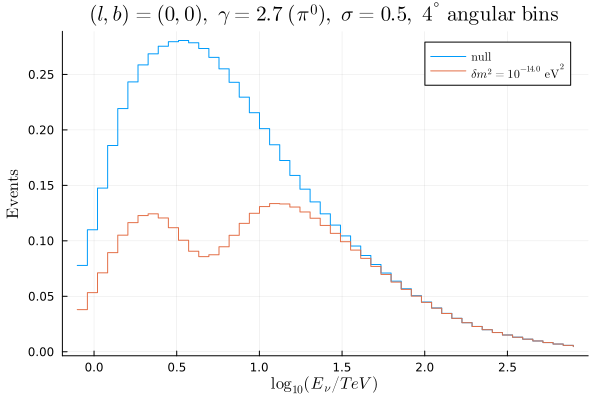

In [8]:
# Plotting pi^0 spectral index

emin = 0.7916819159263001
emax = 791.6819159263017

loges = range(log10(emin), log10(emax), 50)

plot(
    loges, 
    [edistbinned(0, 0, -0.03, 0.5, 2.7, 0.07), edistbinned(10^(-14.0), 0, -0.03, 0.5, 2.7, 0.07)],
    title=L"$(l, b) = (0, 0),~\gamma = 2.7~(\pi^0),~\sigma = 0.5, ~4^{\circ}~\mathrm{angular~bins}$",
    seriestype=:step, 
    label=[L"$\mathrm{null}$" L"$\delta m^2 = 10^{-14.0}~\mathrm{eV}^2$"]
)
xlabel!(L"$\log_{10} (E_{\nu}/TeV)$")
ylabel!(L"\mathrm{Events}")

In [133]:
# Varying ϕ₀, γ:

# ϕ₀ in 1-^-16 TeV^-1 cm^-2
function fluxfreeparams(et, x, y, z, ϕ₀, γ)
    norm = ϕ₀ * (10^(-16)) * 3.156e8 # TeV^-1 cm^-2
    e0 = 100 # TeV
    # γ = 2.0 Completely random, not sure how to calculate this exactly
    probdens(x, y, z)[1] * norm * (et/e0)^(-γ)
end

function smearedeventdistfreeparams(dm2, l, b, σ, ϕ₀, γ, θ, nsteps)
    
    function f(ur)
        et = 10^ur
        r0, rmax = 0, 30
        blength = 0.5
        rbins = range(r0, stop=rmax, step=blength)

        flx = fluxfreeparams.(et, cartx.(rbins, l, b), carty.(rbins, l, b), cartz.(rbins, l, b), ϕ₀, γ) .* blength .* (pi .* (rbins .* tan(θ)) .^ 2)
        probe = oscprob.(et, dm2, rbins)
        effa = effarea(et)[1]*10000

        sum(.*(flx, probe, effa))
    end

    samples = range(-0.5, log10(emax)+0.5, length=300)
    de = samples[2]-samples[1]

    pdf_func(ur) = log(10) * exp10.(ur .- 0) * pdf(Normal(0, σ), abs(1 - exp10(ur - 0)))
    gsample = pdf_func.(samples)
    g_fft = fft(gsample)

    fsample = f.(samples)
    f_fft = fft(fsample)
    C = f_fft .* g_fft
    c = real(ifft(C)) .* de
    
    # Translation factor
    # samples1 = samples .+ 0.5
    
    cut = trunc(Int, (0.5)/de)
    c1 = vcat(c[(cut+1):end], zeros(cut))
    
    fg = interpolate((samples,), c1, Gridded(Linear()))

    loges = range(log10(emin), log10(emax), nsteps)
    output = fg.(loges) ./ 2
end

function edistbinnedfreeparams(dm2, l, b, σ, θ, ϕ₀, γ)
    emin = 0.7916819159263001
    emax = 791.6819159263017
    nbins = 50
    nsteps = 1000
    us = range(log10(emin), log10(emax), nsteps)    
    du = us[2] - us[1]
    steps = smearedeventdistfreeparams(dm2, l, b, σ, ϕ₀, γ, θ, nsteps) .* du .* (10 .^ us) .* log(10)
    matrix = reshape(steps, (20, :)) # This 2 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1)
    νbins = vec(sums)
end

edistbinnedfreeparams (generic function with 1 method)

In [54]:
# Likelihood functions

function poissonlog(data, hyp)
    val = log((hyp^data) * exp(-hyp) / gamma(data+1))
end

# σ = 0.5
function negloglh(dm2, l, b, θ, ϕ₀, γ)

    nullhyp = edistbinnedfreeparams(0, l, b, 0.5, θ, 21.8, 2.7)
    althyp = edistbinnedfreeparams(dm2, l, b, 0.5, θ, ϕ₀, γ)

    altsummand = poissonlog.(nullhyp, althyp)

    nloglh = -sum(altsummand)
end


negloglh (generic function with 2 methods)

In [11]:
# Plotting likelihoods for different parameter values

ϕrange = range(18, 22, length=40)
γrange = range(2, 4, length=40)

grid = Iterators.product(ϕrange, γrange)
lhvals = [negloglh(10^(-14.0), ϕ₀, γ) for (ϕ₀, γ) in grid]
lhmat = reshape(lhvals, length(ϕrange), length(γrange))




40×40 Matrix{Float64}:
 61.7403  59.3143  56.9039  54.5123  …  367.038  455.929  566.504  704.021
 61.653   59.2277  56.8181  54.4276     369.237  458.65   569.87   708.187
 61.5662  59.1417  56.7329  54.3434     371.436  461.371  573.238  712.354
 61.48    59.0562  56.6483  54.2598     373.636  464.094  576.606  716.522
 61.3944  58.9713  56.5642  54.1767     375.837  466.816  579.974  720.69
 61.3093  58.887   56.4808  54.0942  …  378.038  469.54   583.344  724.858
 61.2248  58.8032  56.3978  54.0123     380.239  472.263  586.713  729.027
 61.1409  58.7199  56.3154  53.9309     382.441  474.988  590.083  733.197
 61.0574  58.6372  56.2336  53.85       384.644  477.713  593.454  737.367
 60.9746  58.5551  56.1522  53.7697     386.847  480.438  596.826  741.538
 60.8922  58.4734  56.0715  53.6899  …  389.051  483.164  600.197  745.709
 60.8104  58.3923  55.9912  53.6107     391.255  485.891  603.57   749.881
 60.729   58.3117  55.9114  53.5319     393.46   488.618  606.943  754.053
  ⋮

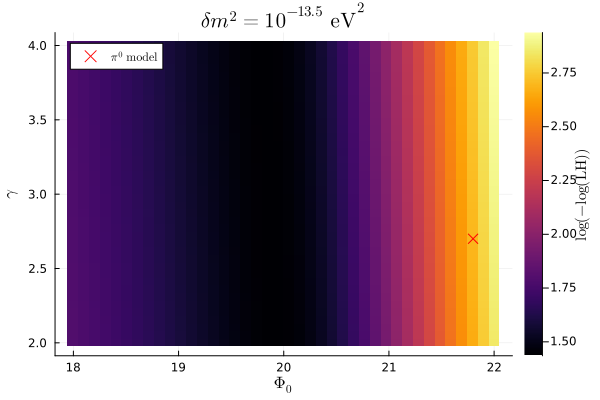

In [12]:
# Finishing the plotting

loglhmat = log10.(lhmat)

hmap = heatmap(
    ϕrange, 
    γrange, 
    loglhmat, 
    ϕlims=(18, 22), 
    γlims=(2, 4), 
    title=L"\delta m^2 = 10^{-13.5}~\mathrm{eV}^2",
    xlabel=L"\Phi_0",
    ylabel=L"\gamma",
    colorbar_title=L"\log(-\log(\mathrm{LH}))"
)
scatter!(hmap, [21.8], [2.7], marker=:x, markersize=5, color=:red, label=L"\pi^0~\mathrm{model}")

In [55]:
# Maximizing the likelihood

function maxlh(dm2, l, b, θ)

    function nllh(test)
        return negloglh(dm2, l, b, θ, test[1], test[2])
    end

    x0 = [21.8, 2.7]

    optimize(nllh, x0, NelderMead())
end


maxlh (generic function with 2 methods)

In [105]:
# Plotting max likelihood results

function maxlhplots(dm2, l, b, θ)

    res = maxlh(dm2, l, b, θ)
    params = Optim.minimizer(res)

    emin = 0.7916819159263001
    emax = 791.6819159263017

    logdm2 = log10(dm2)
    loges = range(log10(emin), log10(emax), 50)

    plot(
        loges, 
        [edistbinnedfreeparams(0, l, b, 0.5, θ, 21.8, 2.7), edistbinnedfreeparams(dm2, l, b, 0.5, θ, params[1], params[2])],
        title="($l, $b), $logdm2 log eV",
        seriestype=:step, 
        label=[L"$\mathrm{null}$" L"$\mathrm{alt~(max~LH)}$"]
    )
    xlabel!(L"$\log_{10} (E_{\nu}/\mathrm{TeV})$")
    ylabel!(L"\mathrm{Events}")
end

maxlhplots (generic function with 1 method)

In [165]:
Plots.set_default_backend!()

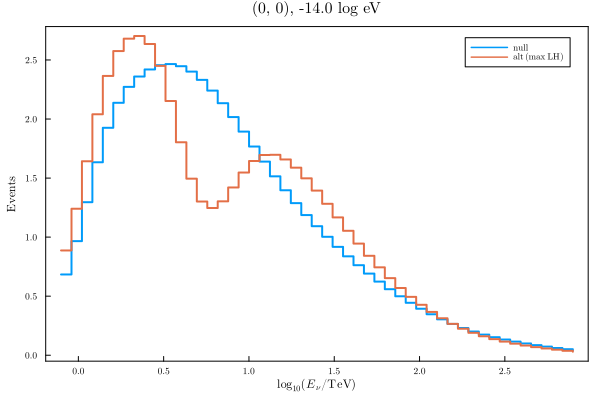

In [166]:
maxlhplots(10^(-14), 0, 0, 0.122)

In [118]:
# Plotting max lh parameter values

logdm2s = range(-16, -12, length=40)
dm2s = 10 .^ (logdm2s)

params = Optim.minimizer.(maxlh.(dm2s, 0, 0, 0.122))

ϕs = [params[i][1] for i in 1:40]
γs = [params[i][2] for i in 1:40]

color_vector=[logdm2s[i] for i in 1:40]

scatter(
    ϕs, 
    γs, 
    marker_z=color_vector, 
    xlabel=L"\Phi_0",
    ylabel=L"\gamma",
    label=false,
    title="Max LH parameter values", 
    colorbar_title=L"\log \delta m^2")

LoadError: InterruptException:

In [140]:
# Getting all-sky results

# Loading an all sky event distribution sample

# Define the range of x and y values
l_range = (0):0.07:(2*pi)
b_range = (0):0.07:(pi)

# Create empty arrays to store the function values
function_values = []

# Evaluate the function on the grid of points
for l in l_range
    for b in b_range
        # I'm making the angular sampling of 0.07 rad be the same as the bin width, 
        # so (I think?) this then gets the whole sky
        push!(function_values, edistbinnedfreeparams(0, l, (pi/2 - b), 0.5, 0.07, 21.8, 2.7))
    end
end

# Convert the list of function values to a 2D array
edistvals = reshape(function_values, length(b_range), length(l_range))
edistvals1 = edistvals'

90×45 adjoint(::Matrix{Any}) with eltype Any:
 [3.59916e-7 5.08537e-7 … 2.66917e-8 2.14425e-8]  …  [1.15304e-6 1.62917e-6 … 8.55106e-8 6.86943e-8]
 [3.59916e-7 5.08537e-7 … 2.66917e-8 2.14425e-8]     [1.15529e-6 1.63234e-6 … 8.5677e-8 6.88279e-8]
 [3.59916e-7 5.08537e-7 … 2.66917e-8 2.14425e-8]     [1.15698e-6 1.63473e-6 … 8.58023e-8 6.89286e-8]
 [3.59916e-7 5.08537e-7 … 2.66917e-8 2.14425e-8]     [1.1581e-6 1.63633e-6 … 8.58861e-8 6.89959e-8]
 [3.59916e-7 5.08537e-7 … 2.66917e-8 2.14425e-8]     [1.15867e-6 1.63712e-6 … 8.5928e-8 6.90296e-8]
 [3.59916e-7 5.08537e-7 … 2.66917e-8 2.14425e-8]  …  [1.15867e-6 1.63712e-6 … 8.59279e-8 6.90295e-8]
 [3.59916e-7 5.08537e-7 … 2.66917e-8 2.14425e-8]     [1.1581e-6 1.63632e-6 … 8.58859e-8 6.89957e-8]
 [3.59916e-7 5.08537e-7 … 2.66917e-8 2.14425e-8]     [1.15697e-6 1.63473e-6 … 8.58022e-8 6.89285e-8]
 [3.59916e-7 5.08537e-7 … 2.66917e-8 2.14425e-8]     [1.15529e-6 1.63235e-6 … 8.56774e-8 6.88282e-8]
 [3.59916e-7 5.08537e-7 … 2.66917e-8 2.14425e-8] 

In [142]:
# Now the data are split into all-sky maps for each energy bin

matrix = zeros(length(l_range), length(b_range))
ebins = [copy(matrix) for _ in 1:50]
for i in 1:50
    for j in 1:length(l_range)
        for k in 1:length(b_range)
            ebins[i][j, k] = edistvals1[j, k][i]
        end
    end
end

In [170]:
# Converting from angles to the appropriate pixels in the Healpix scheme

nside = 150
npix = hp.nside2npix(nside)
thedges = np.arange(0, np.pi, 0.07)
phedges = np.arange(0, 2*np.pi, 0.07)
theta, phi = np.meshgrid(thedges, phedges)
pixel_indices = hp.ang2pix(nside, vec(theta), vec(phi)) .+ 1 # the addition is for changing indexing to Julia indexing


# Smooths the sky by whatever number of degrees we want for a given energy bin

function dist(index)

    # bin = reshape(ebins[index], 45, 90)
    bin = ebins[index]
    e = []
    
    for (j, thval) in enumerate(thedges)
        for (i, phval) in enumerate(phedges)
                push!(e, bin[i, j])
        end
    end

    E = np.zeros(hp.nside2npix(nside))

    # E[pixel_indices] = e
    
    for (i, eval) in enumerate(e)
        E[pixel_indices[i]] = eval
    end
    
    E_smoothing = hp.smoothing(E, fwhm=np.radians(7.))

    twod_array = hp.cartview(E_smoothing, return_projected_map=true) 
end


# Binning into angular bins
# For this 400x800 matrix, each pixel represents a 0.007854 radian^2 angular bin, so 16 pixels is 7.2 degrees

function bin7ish(index)
    ebin = dist(index)

    bsize_l = 16
    bsize_b = 16

    nbins_l = convert(Int, (size(ebin, 1)/bsize_l))
    nbins_b = convert(Int, (size(ebin, 2)/bsize_b))

    binned_mat = reshape(ebin, bsize_l, nbins_l, bsize_b, nbins_b)

    bins = sum(binned_mat, dims=(1, 3))

    binned_sums = reshape(bins, nbins_l, nbins_b)
end

bin7ish (generic function with 1 method)

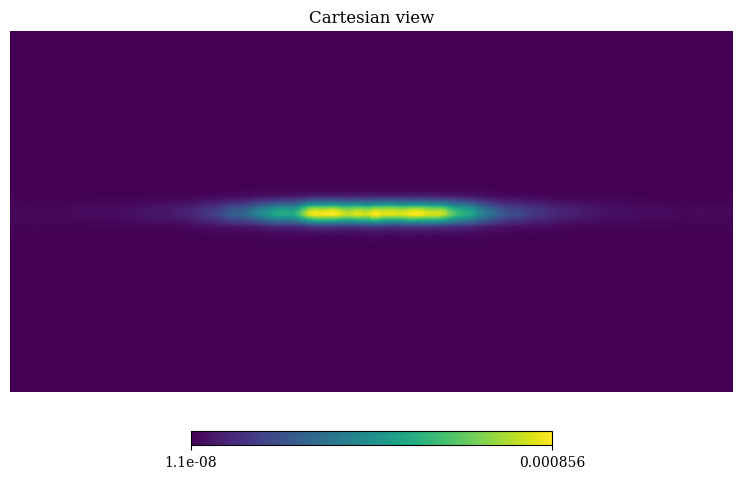

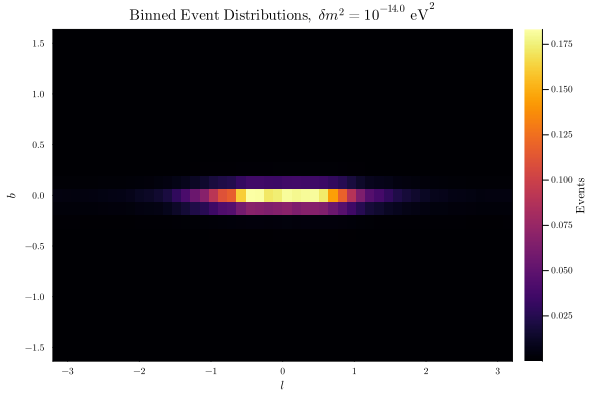

In [167]:
# Printing a single binned skymap

lvals = range(-pi, pi, length=50)
bvals = range(-pi/2, pi/2, length=25)

hm_binned = heatmap(
    lvals, 
    bvals, 
    bin7ish(4), 
    xlabel=L"l", 
    ylabel=L"b", 
    title=L"\textrm{Binned~Event~Distributions},~\delta m^2 = 10^{-14.0}~\textrm{eV}^2",
    colorbar_title=L"\textrm{Events}",
    colorbar_width=(5, :mm),
    # colorbar_ticks=([0, 0.13], ["0", "0.13"]),
    # aspect_ratio=:equal,
    )

/Users/millermacdonald/.julia/conda/3/x86_64/lib/python3.10/site-packages/healpy/visufunc.py:764: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = pylab.figure(fig, figsize=(8.5, 5.4))


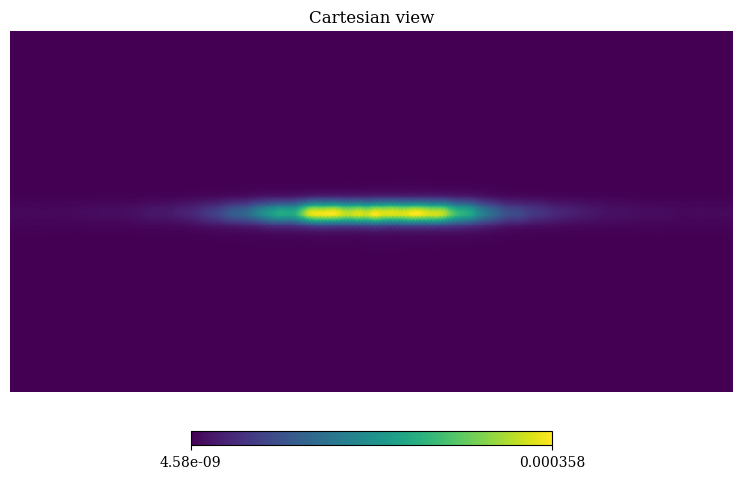

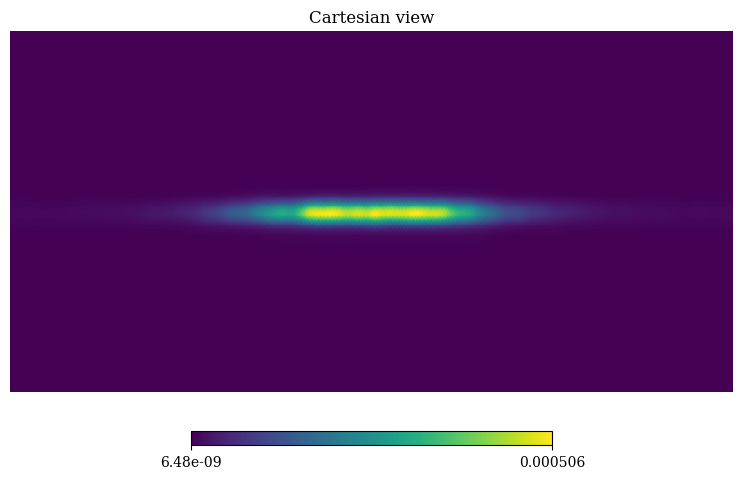

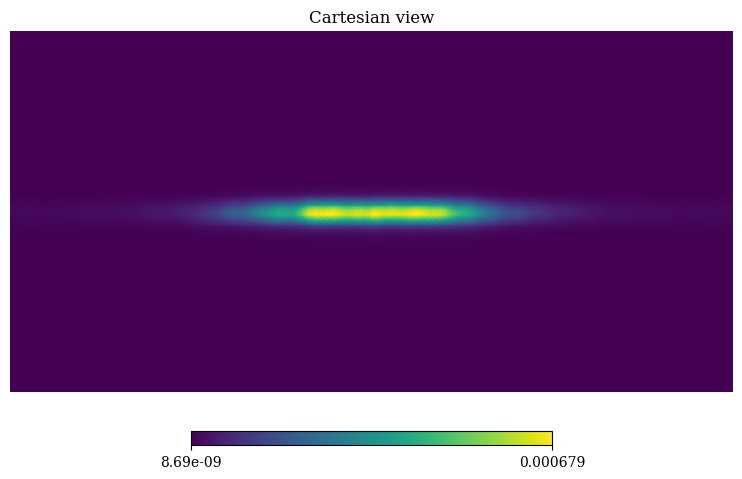

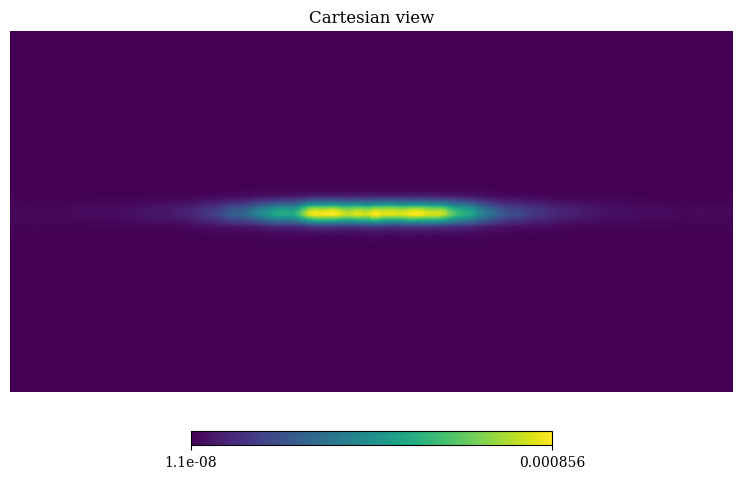

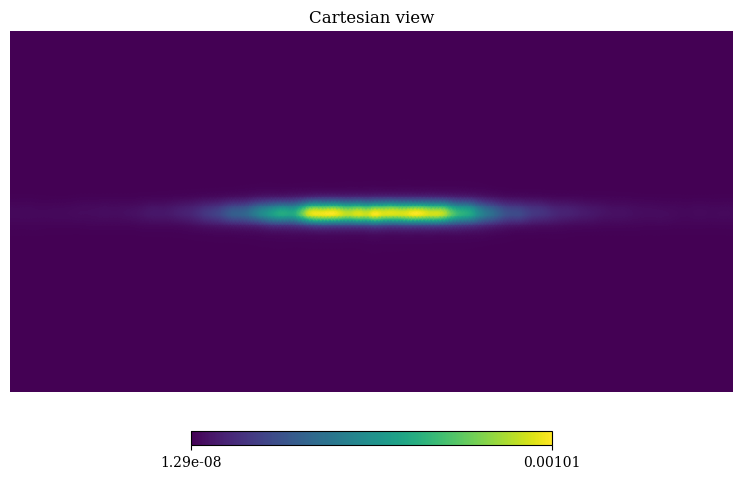

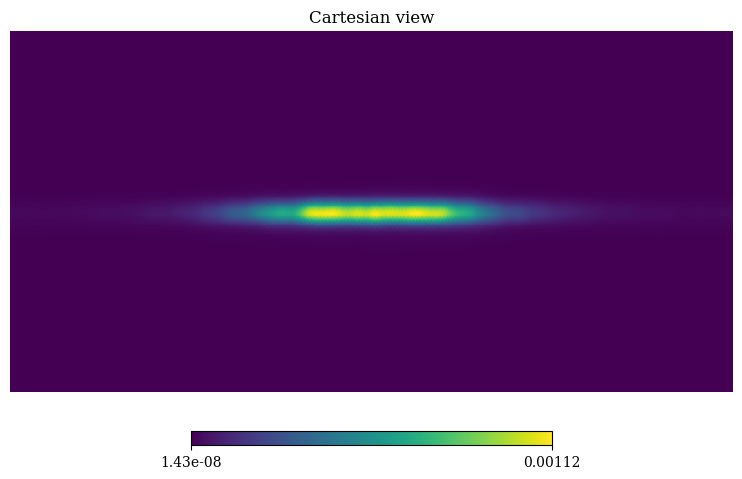

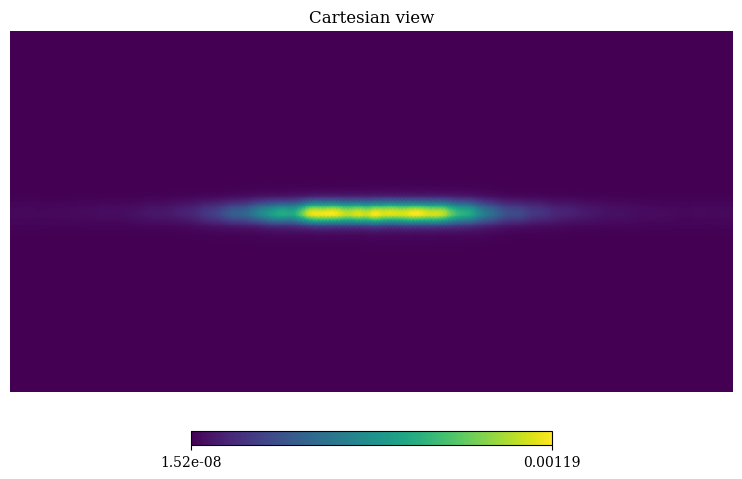

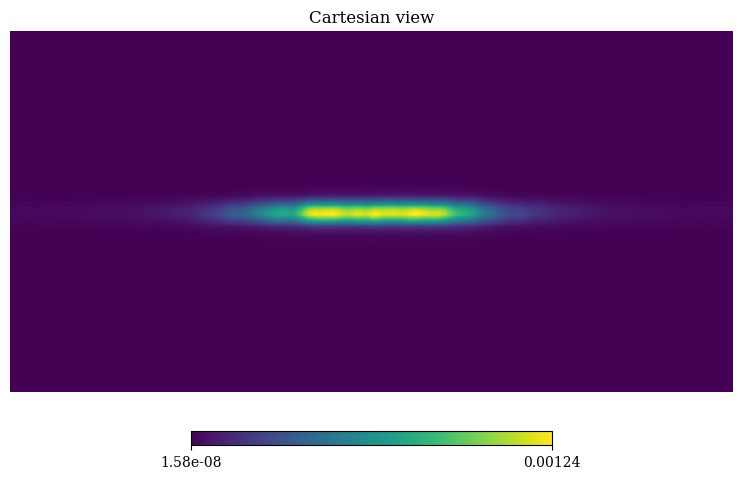

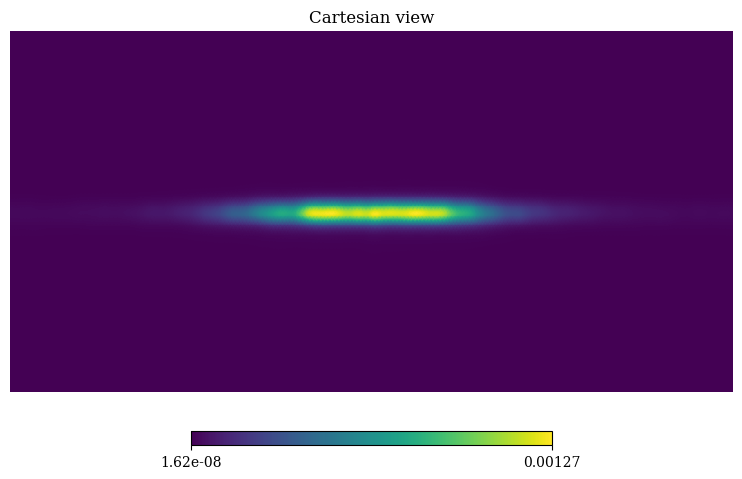

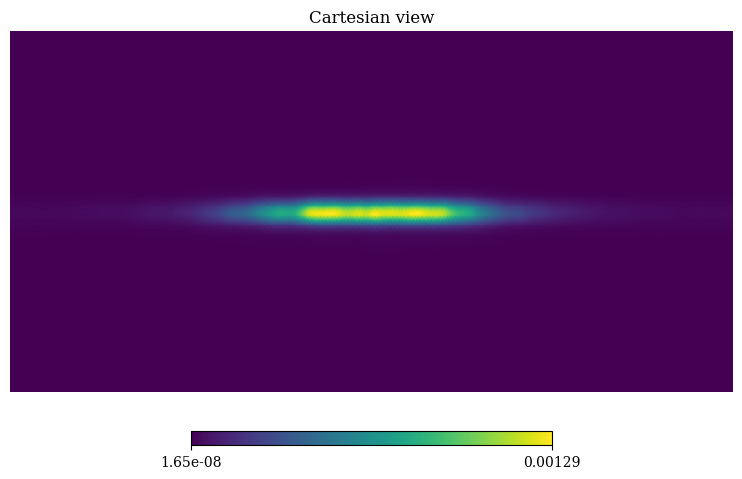

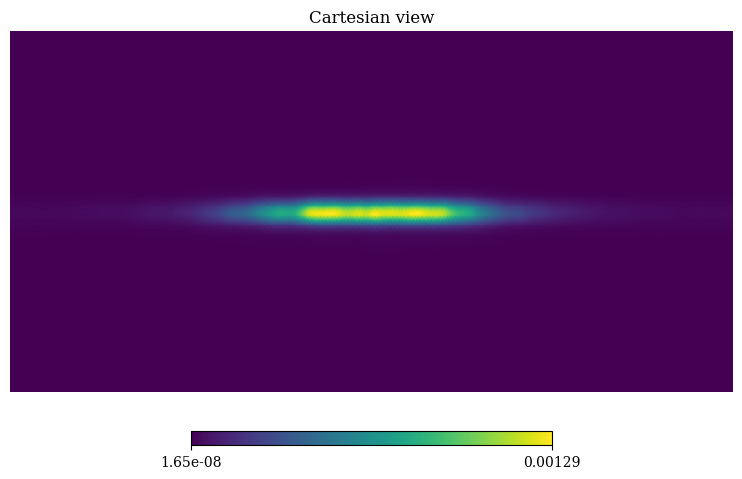

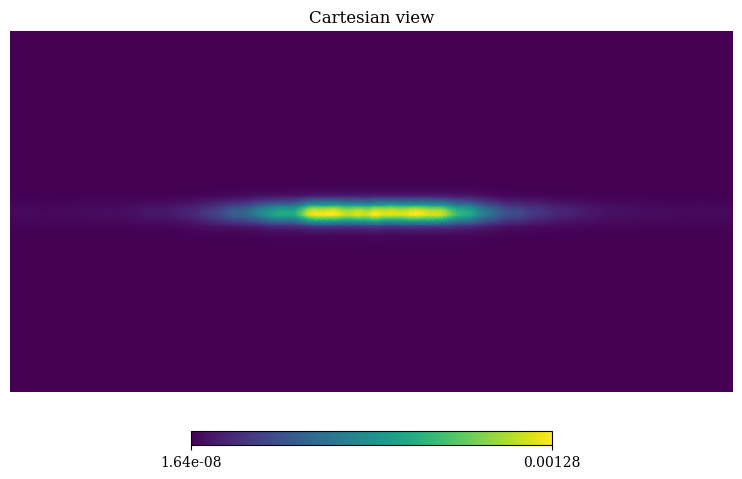

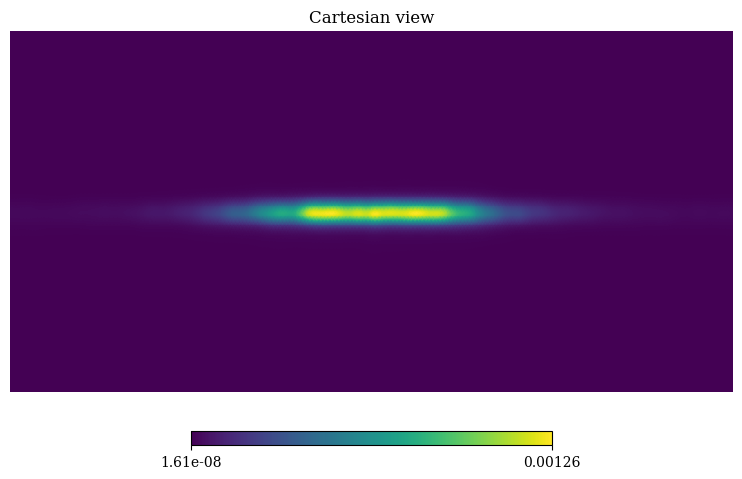

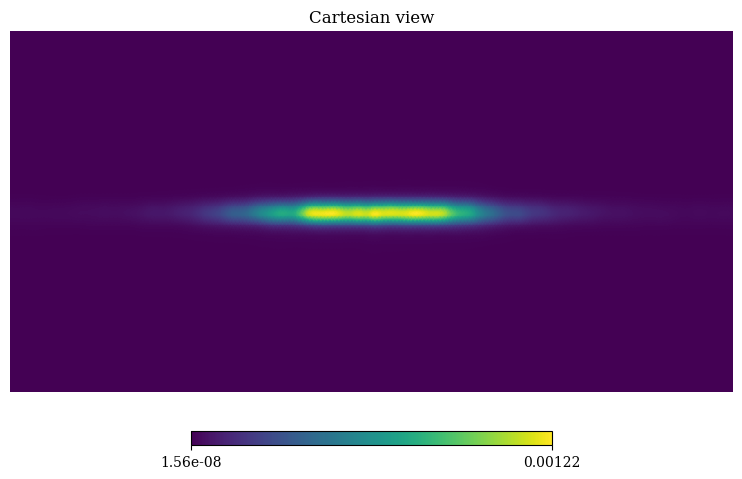

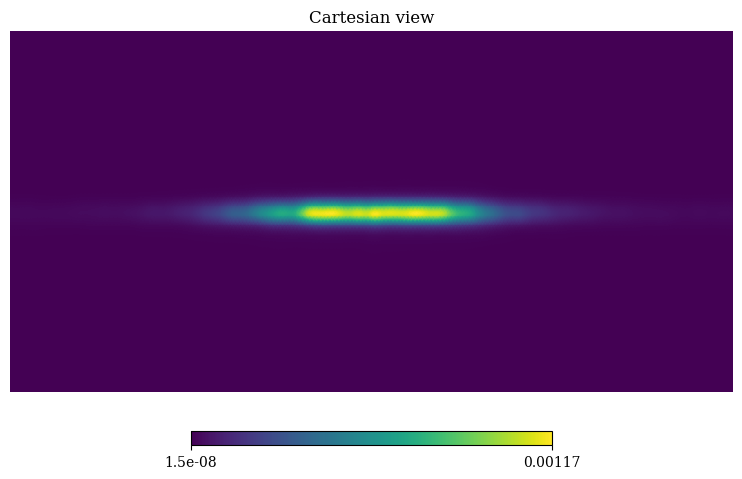

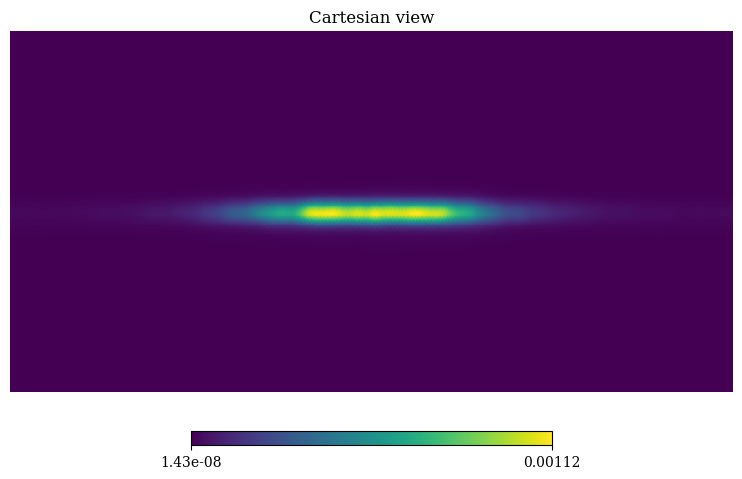

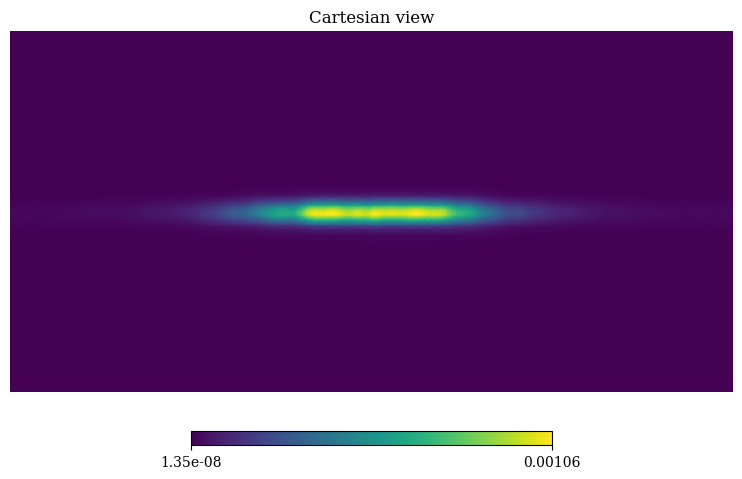

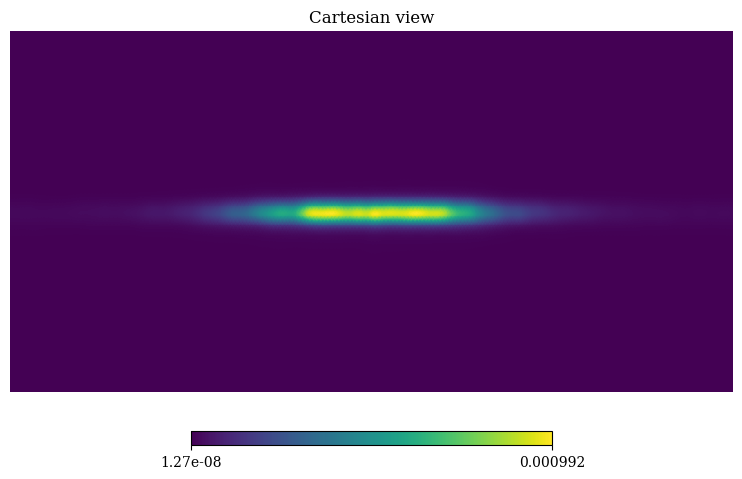

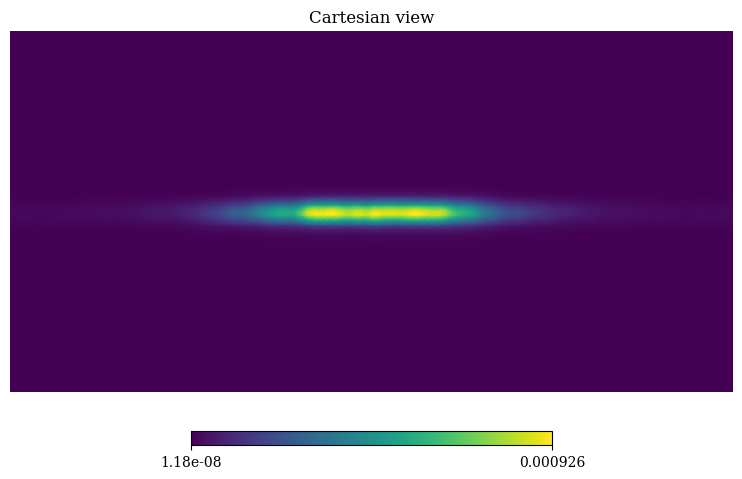

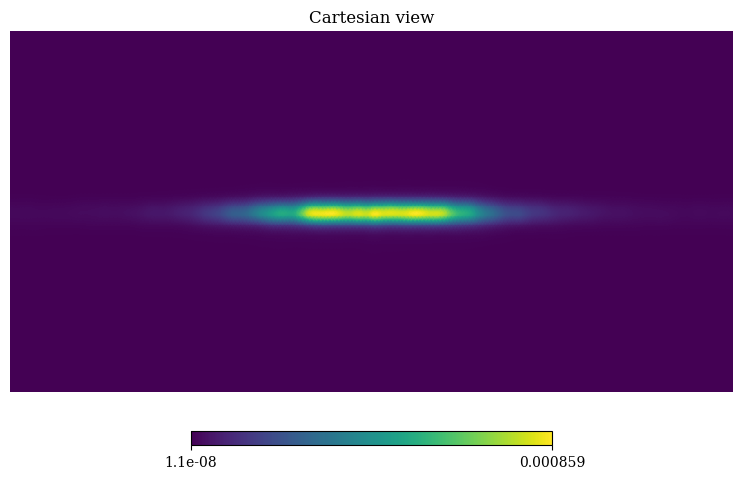

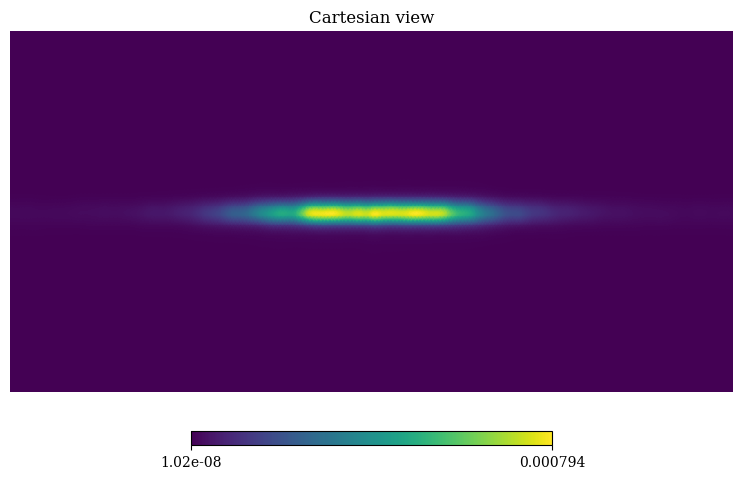

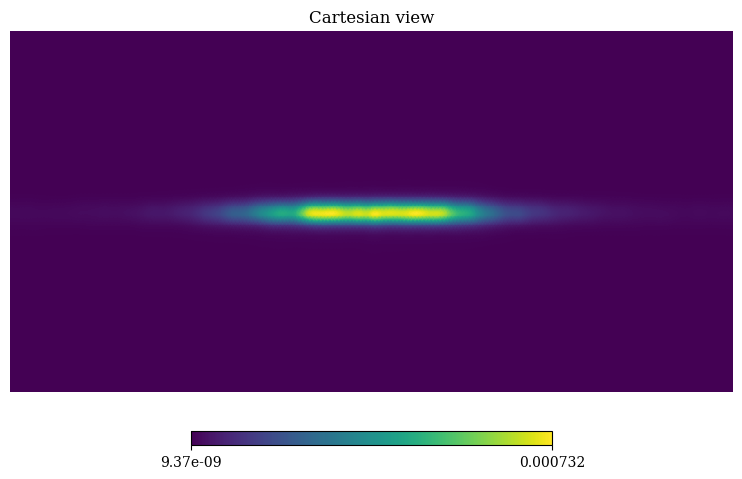

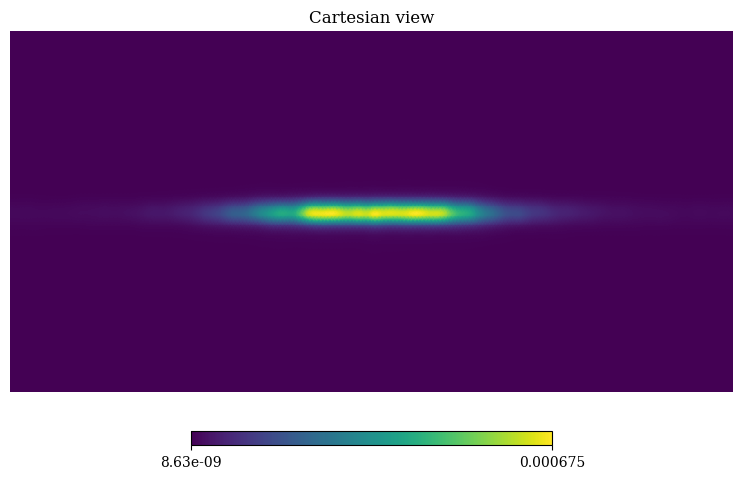

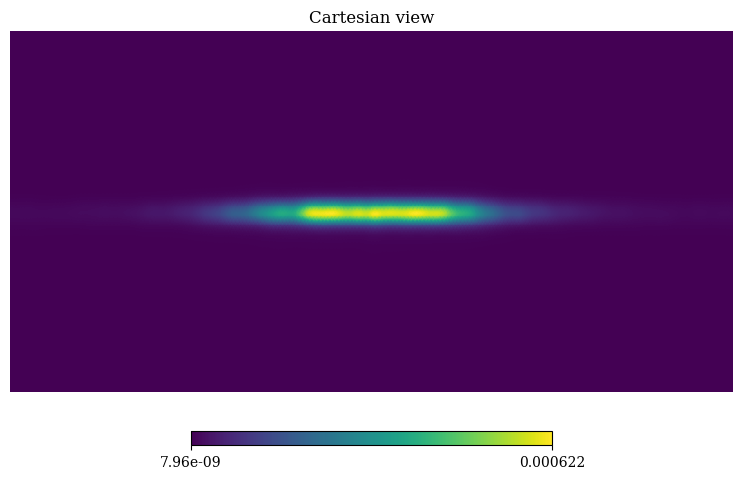

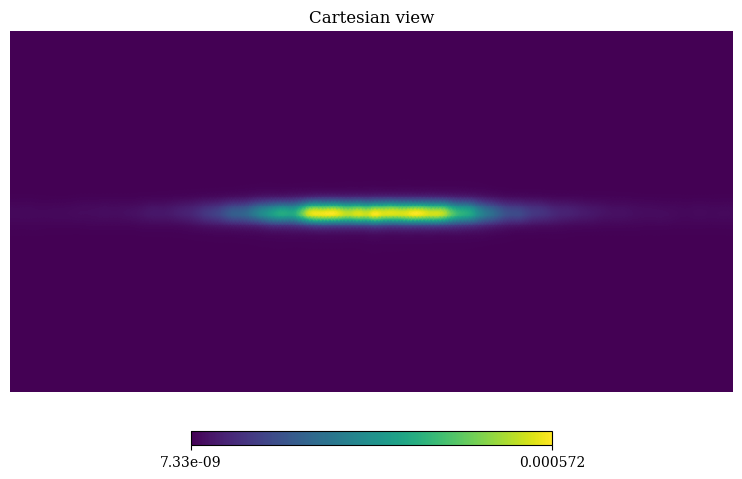

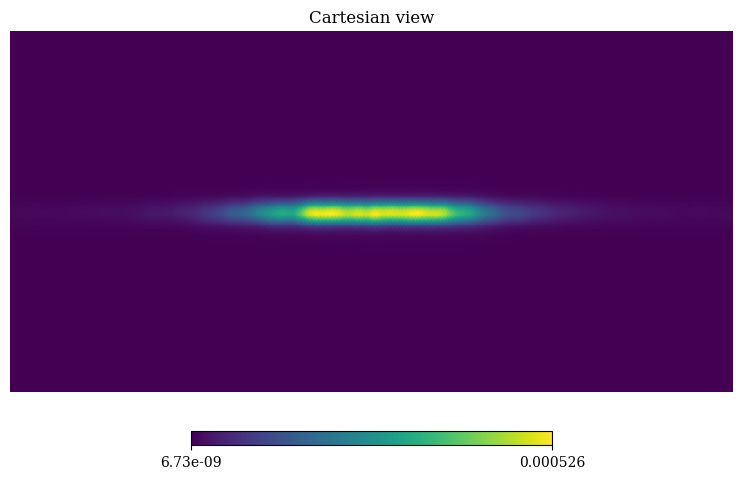

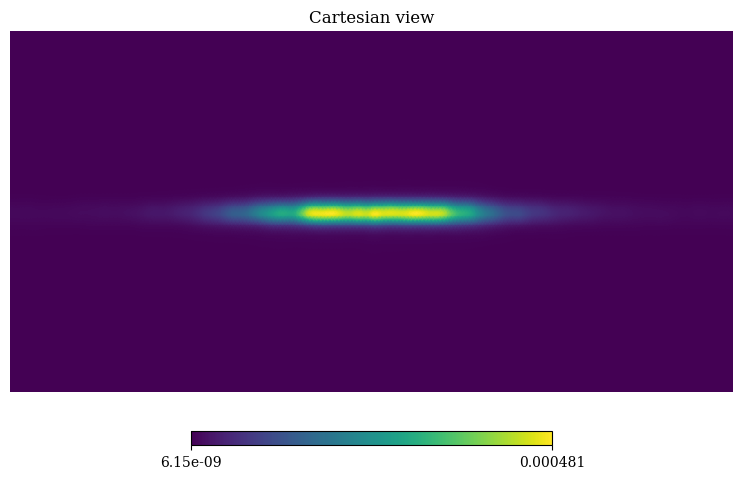

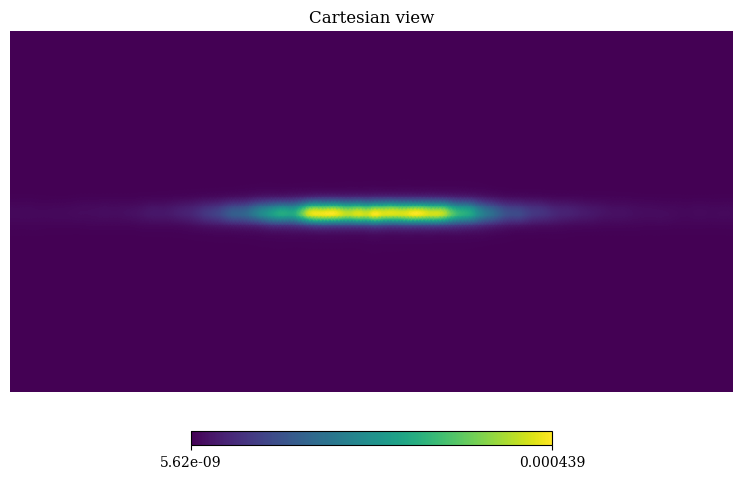

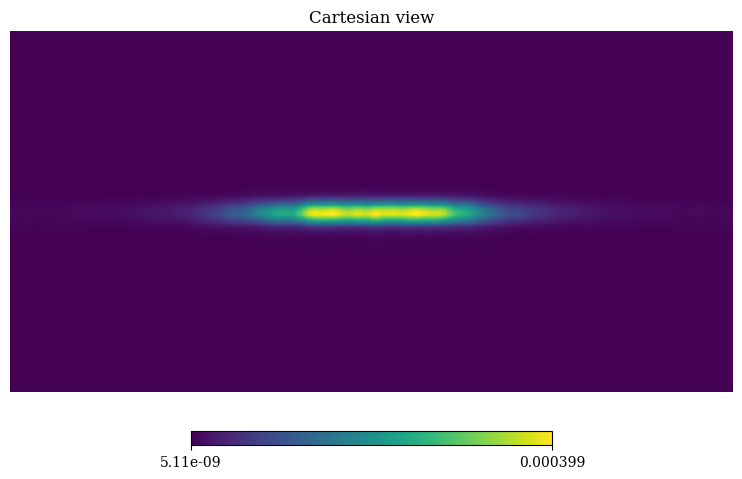

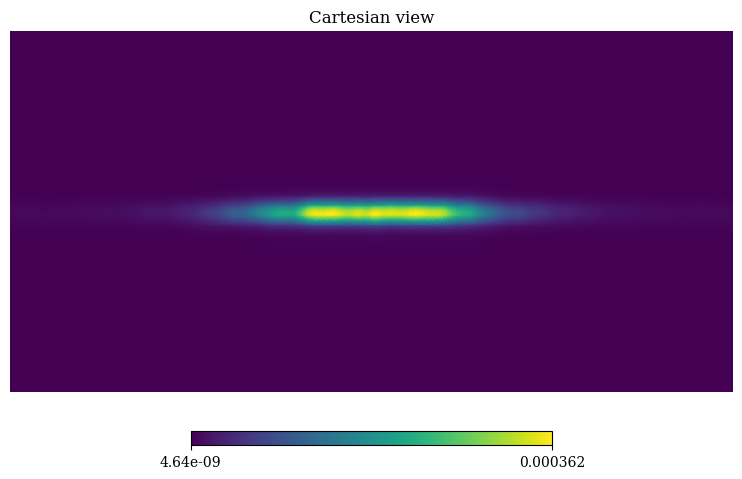

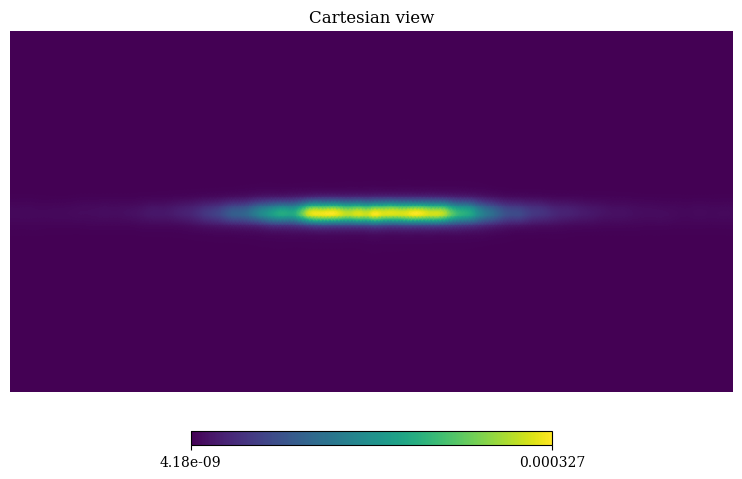

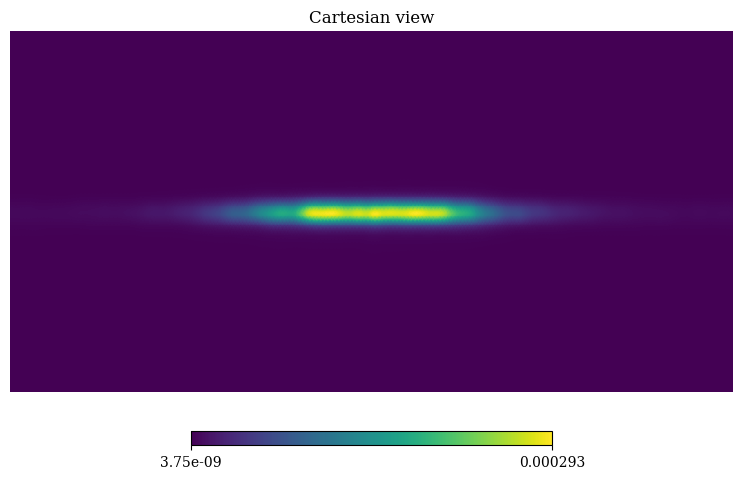

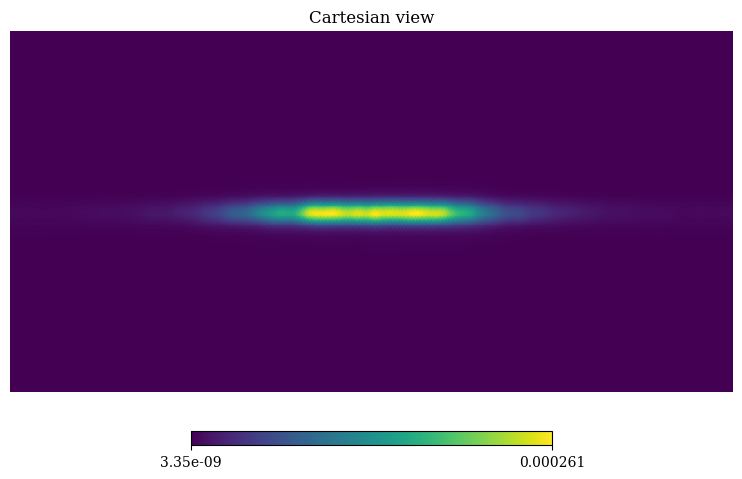

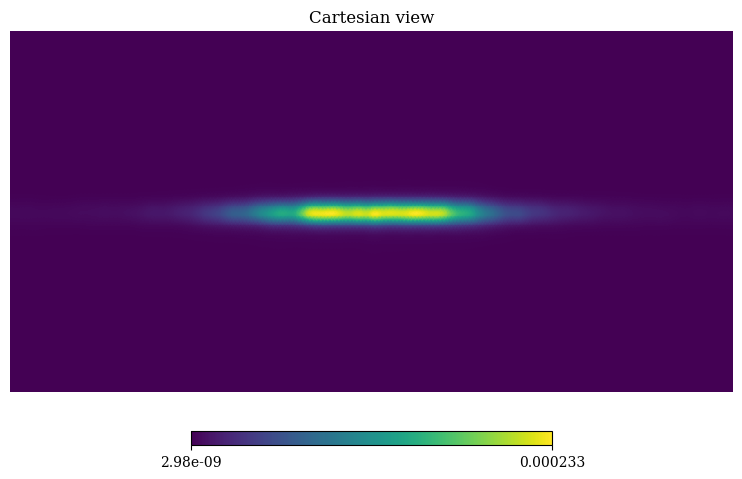

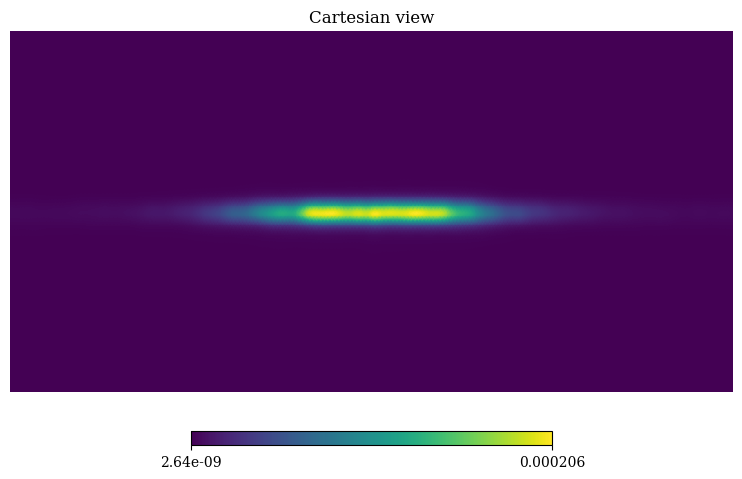

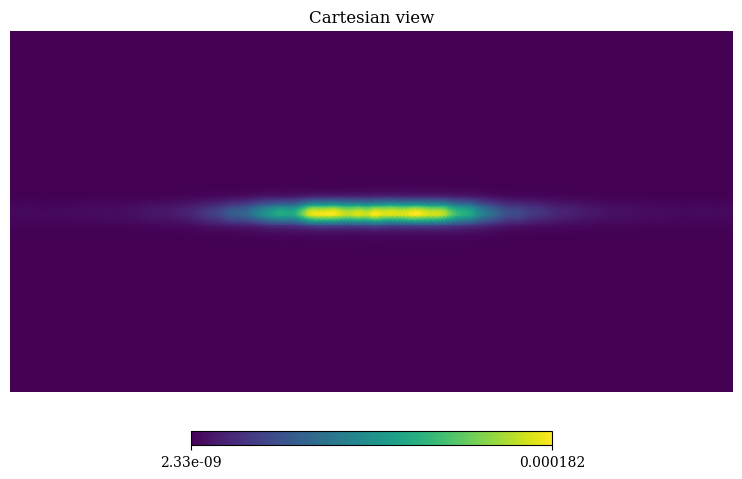

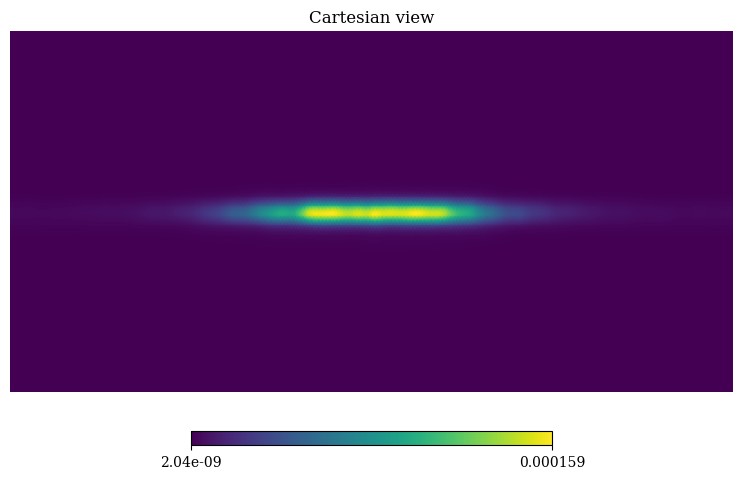

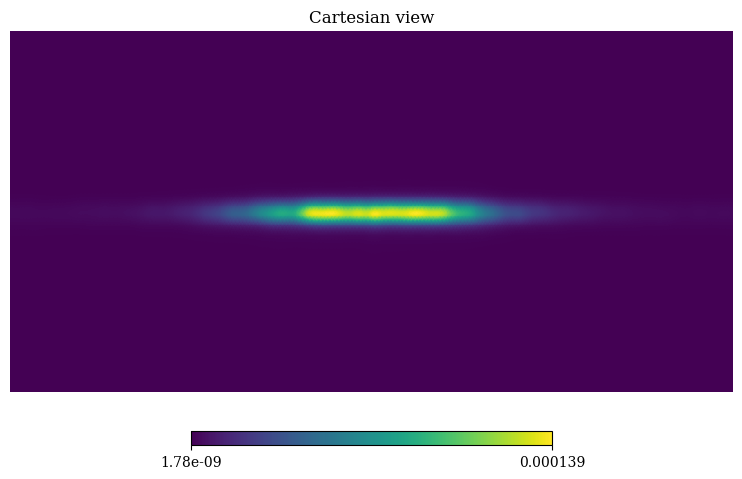

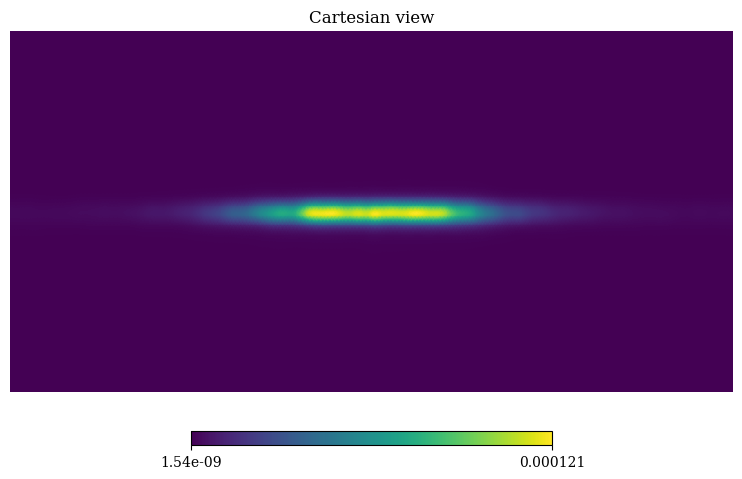

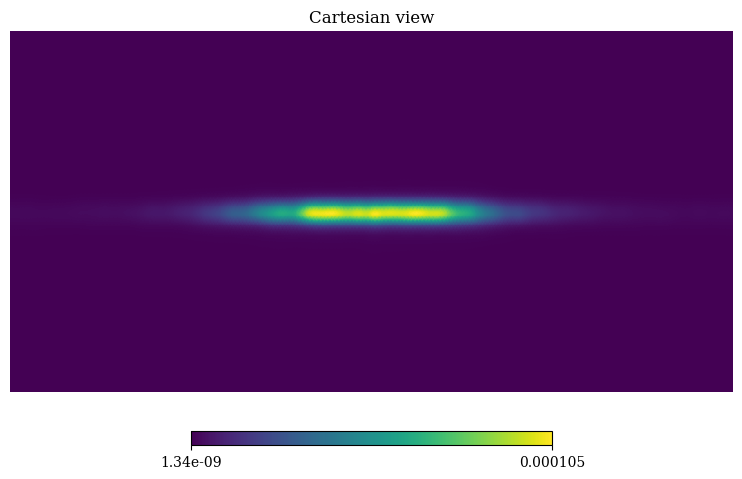

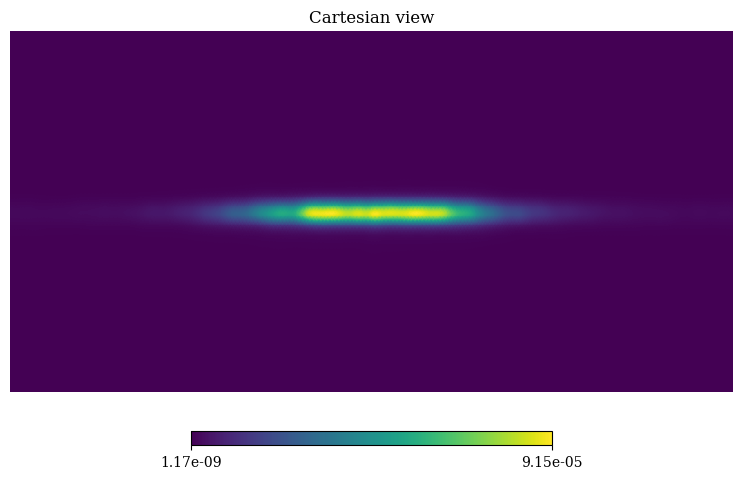

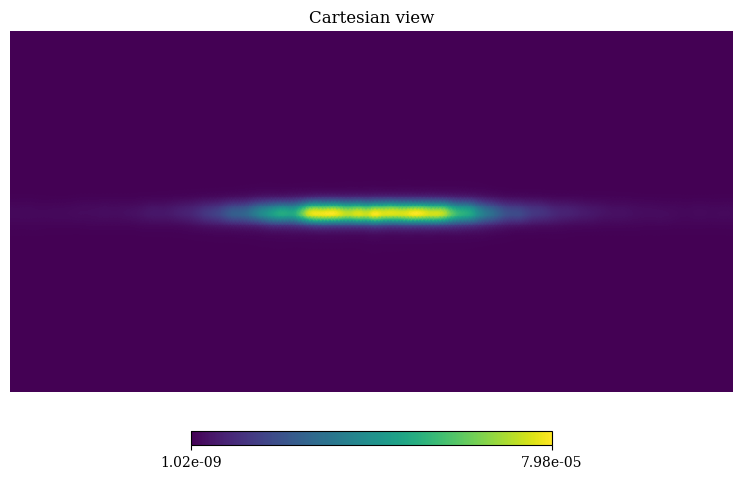

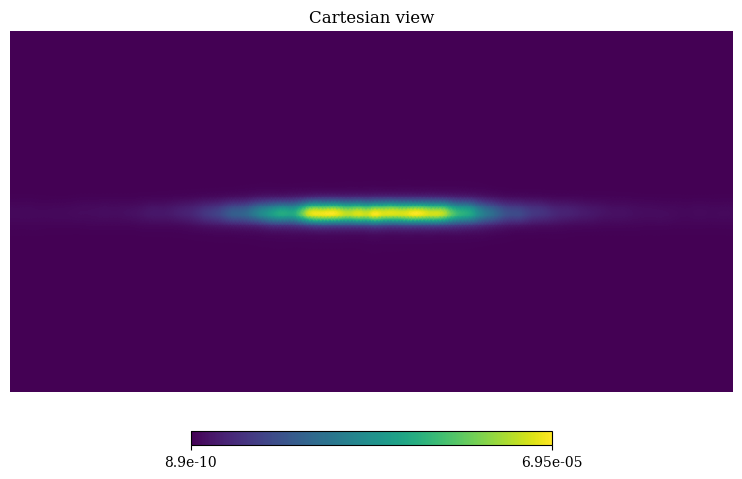

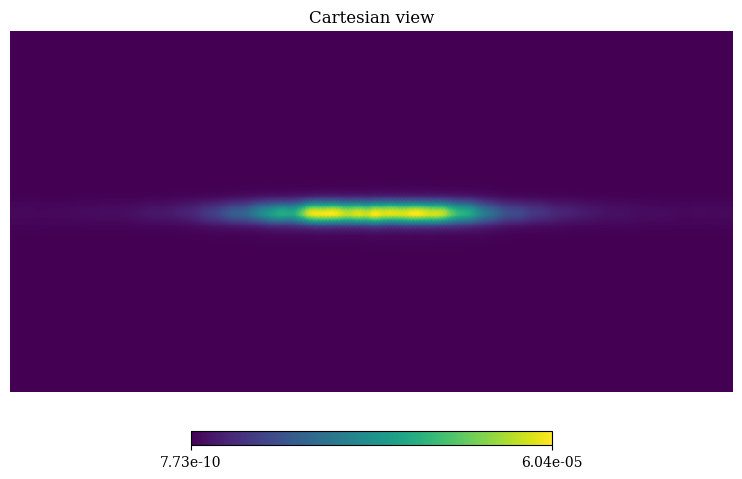

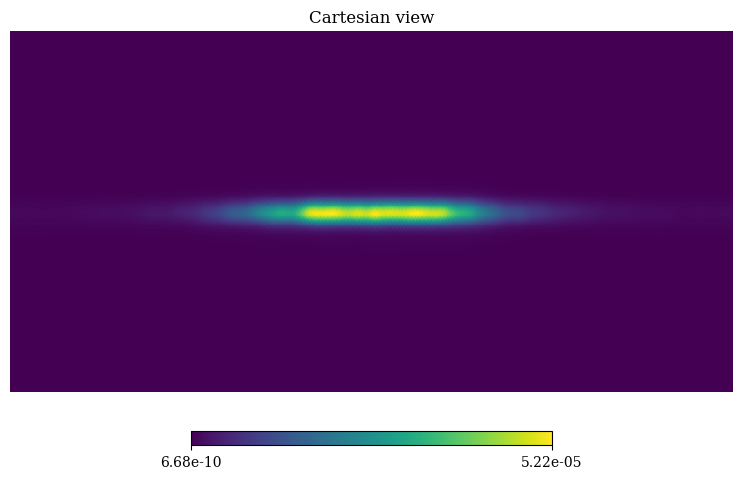

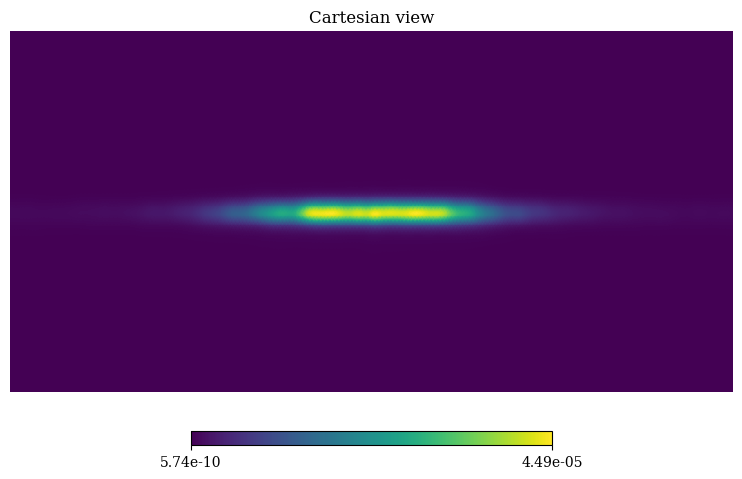

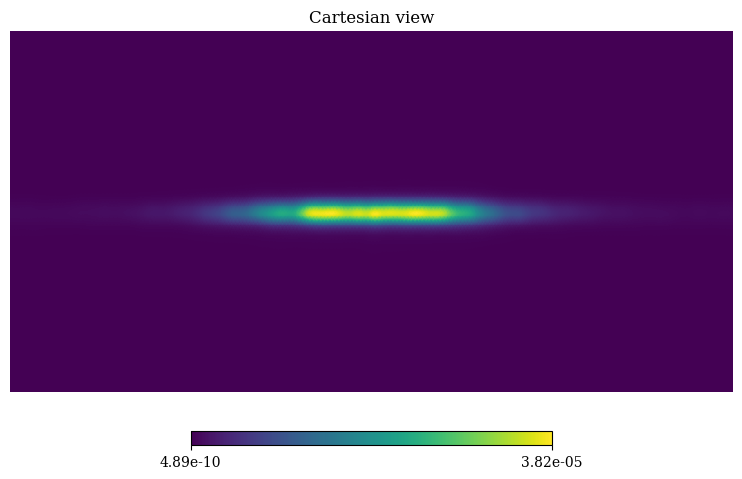

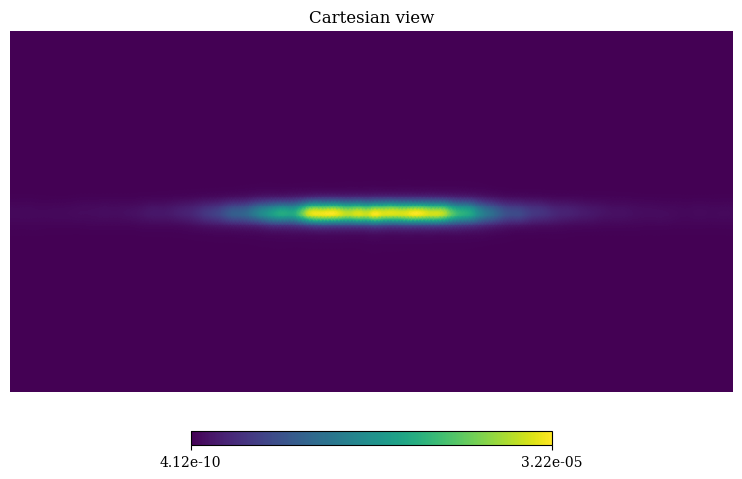

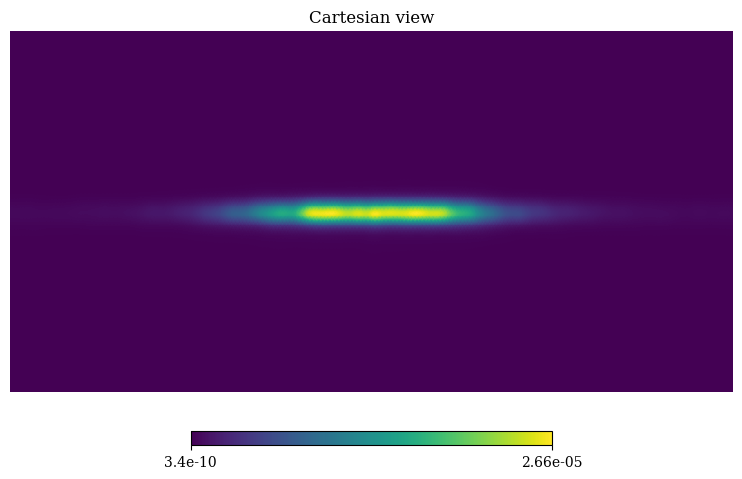

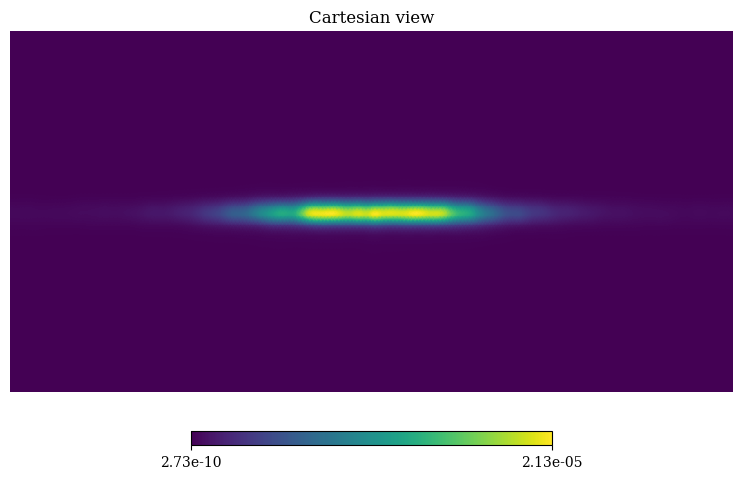

50-element Vector{Matrix{Float64}}:
 [1.0395791552749947e-5 1.0130621979071335e-5 … 1.0682046590712473e-5 1.0578830081465057e-5; 1.1825798282935851e-5 1.1812443018536967e-5 … 1.2406512362822269e-5 1.2023947335509974e-5; … ; 6.447359379136109e-6 6.4196382161718605e-6 … 6.442588798752715e-6 6.452874727812436e-6; 4.5074596614785674e-5 4.5644397107579715e-5 … 4.5647900470601674e-5 4.507191672557345e-5]
 [1.4688573451248373e-5 1.4313906188997411e-5 … 1.5093033095287838e-5 1.494719491934928e-5; 1.670907942101391e-5 1.669020930602148e-5 … 1.7529590430039368e-5 1.6989051070910887e-5; … ; 9.109697066054372e-6 9.070528876095717e-6 … 9.102956548022233e-6 9.117489892959059e-6; 6.368745658317767e-5 6.4492547407532e-5 … 6.449749743031783e-5 6.368367007501817e-5]
 [1.9705765503593028e-5 1.920312273598051e-5 … 2.0248376869326297e-5 2.00527245885914e-5; 2.2416417900903742e-5 2.2391102300151433e-5 … 2.351719175007818e-5 2.27920197725754e-5; … ; 1.2221306227486532e-5 1.216875931616574e-5 … 1.221226334335

In [172]:
allsky_ebins = [bin7ish(ebin) for ebin in 1:50]

In [191]:
# Big boy smearing and binning function

function anglesmearbin(dm2, ϕ₀, γ)

    # Define the range of x and y values
    l_range = (0):0.07:(2*pi)
    b_range = (0):0.07:(pi)

    # Create empty arrays to store the function values
    function_values = []

    # Evaluate the function on the grid of points
    for l in l_range
        for b in b_range
            # I'm making the angular sampling of 0.07 rad be the same as the bin width, 
            # so (I think?) this then gets the whole sky
            push!(function_values, edistbinnedfreeparams(dm2, l, (pi/2 - b), 0.5, 0.07, ϕ₀, γ))
        end
    end

    # Convert the list of function values to a 2D array
    edistvals = reshape(function_values, length(b_range), length(l_range))
    edistvals1 = edistvals'

    # Now the data are split into all-sky maps for each energy bin
    matrix = zeros(length(l_range), length(b_range))
    ebins = [copy(matrix) for _ in 1:50]
    for i in 1:50
        for j in 1:length(l_range)
            for k in 1:length(b_range)
                ebins[i][j, k] = edistvals1[j, k][i]
            end
        end
    end

    allsky_ebins = [bin7ish(ebin) for ebin in 1:50]

    allskyedists = [zeros(50) for _ in 1:25, _ in 1:50]

    for i in 1:25
        for j in 1:50
            allskyedists[i, j] = [allsky_ebins[k][i, j] for k in 1:50]
        end
    end

end


anglesmearbin (generic function with 1 method)

141.269643 seconds (1.08 G allocations: 32.615 GiB, 9.55% gc time)


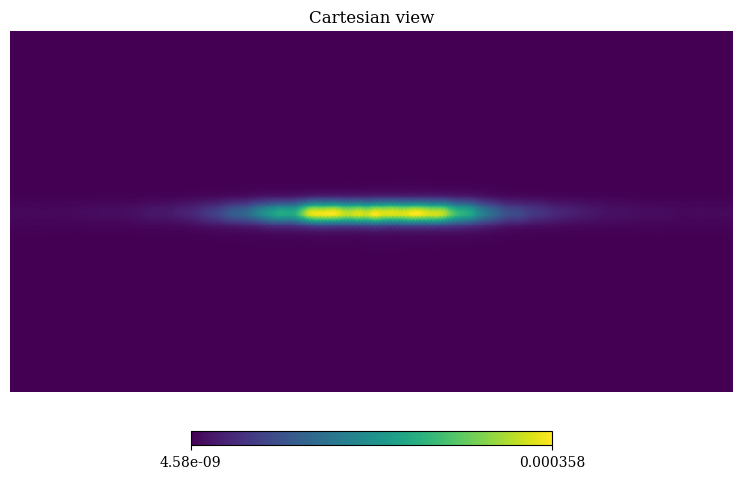

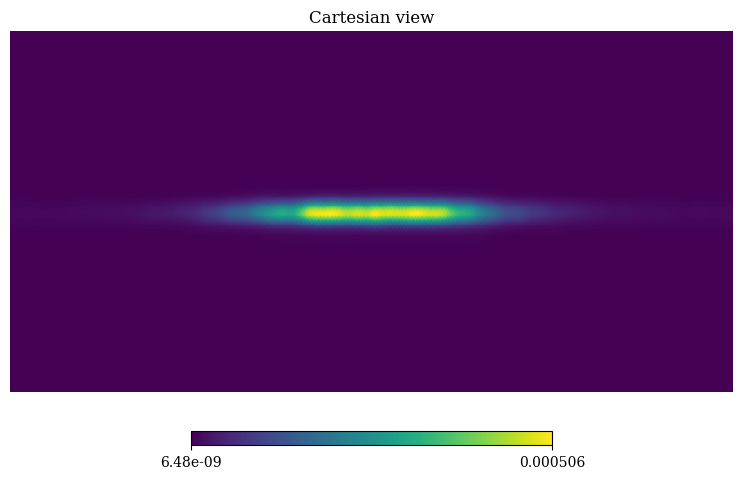

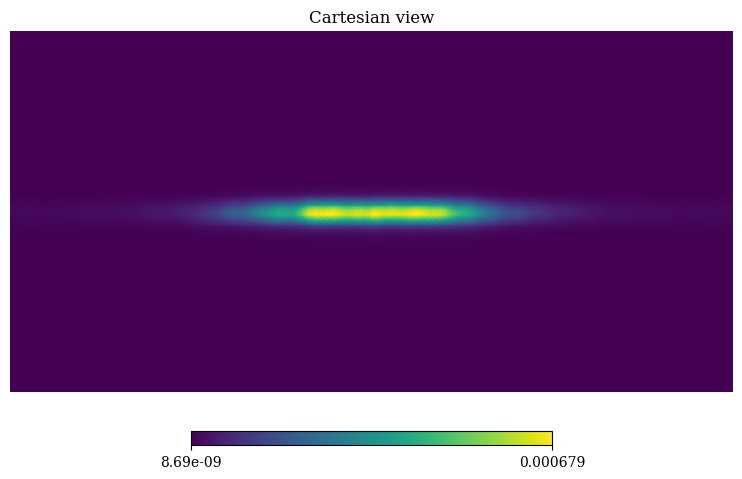

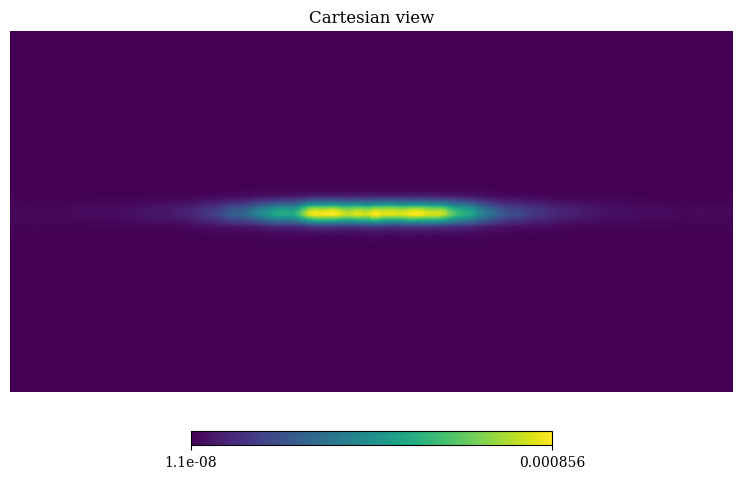

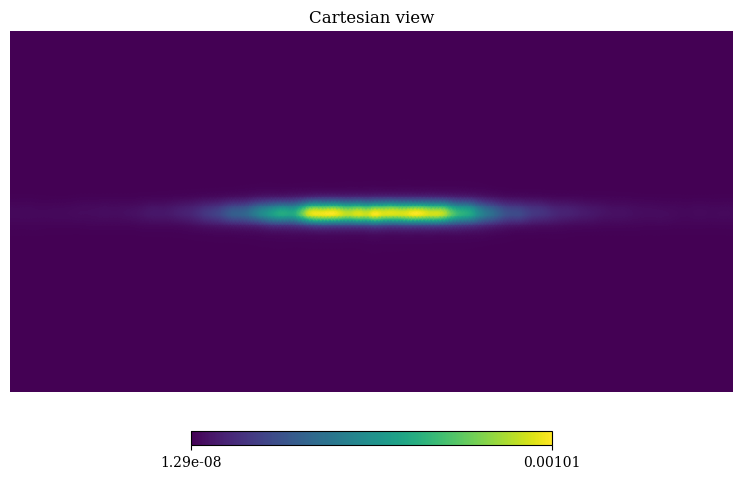

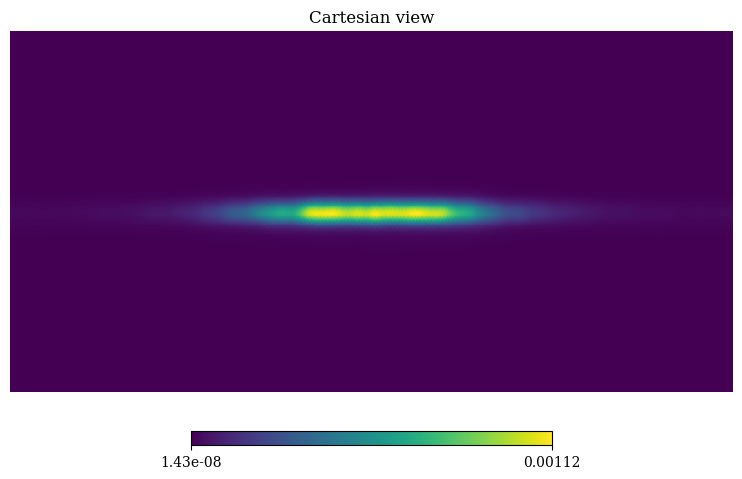

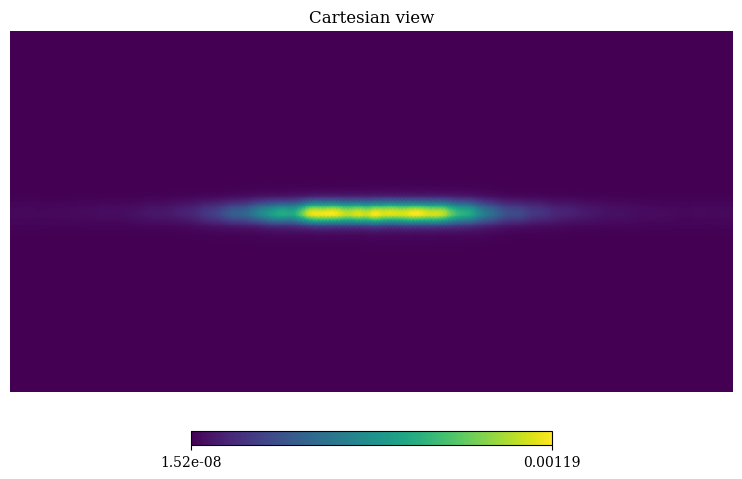

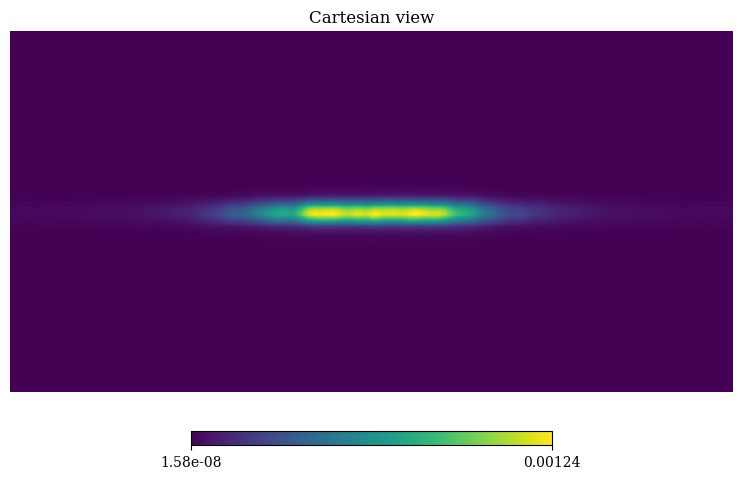

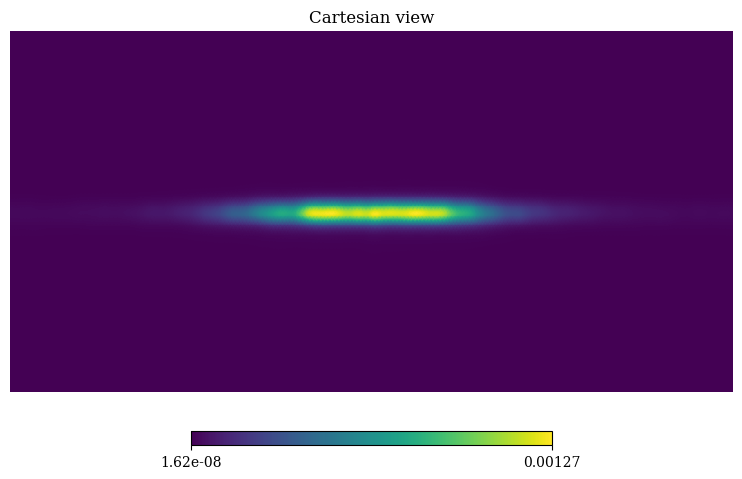

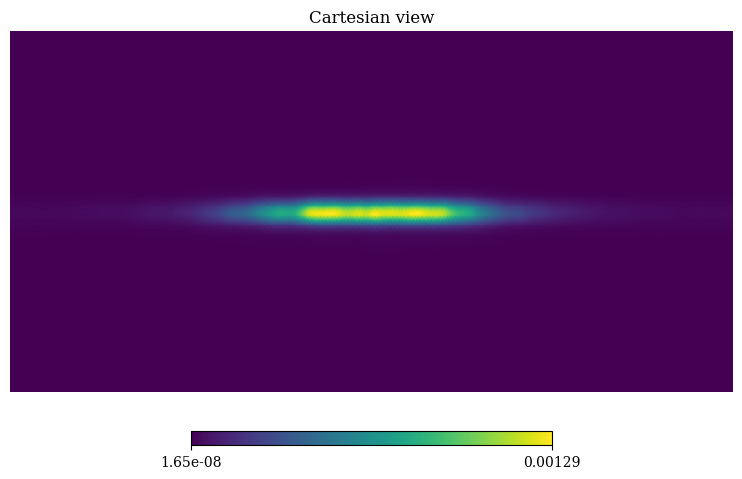

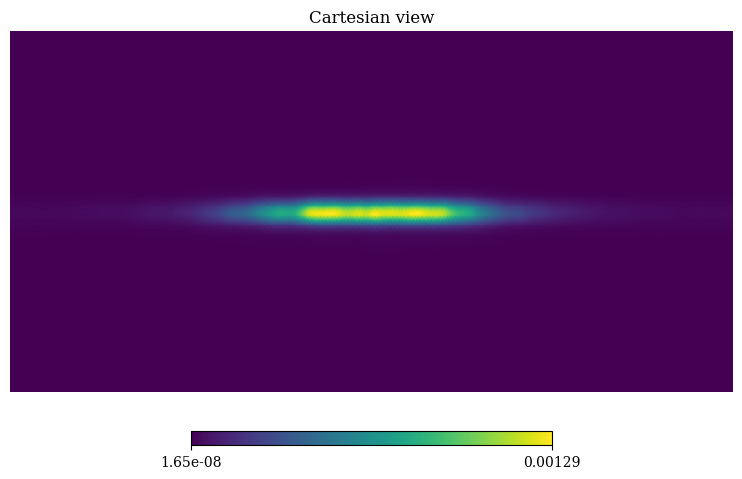

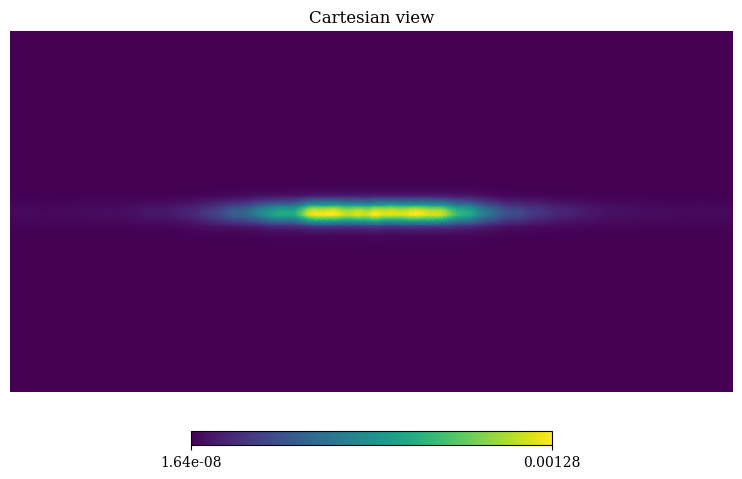

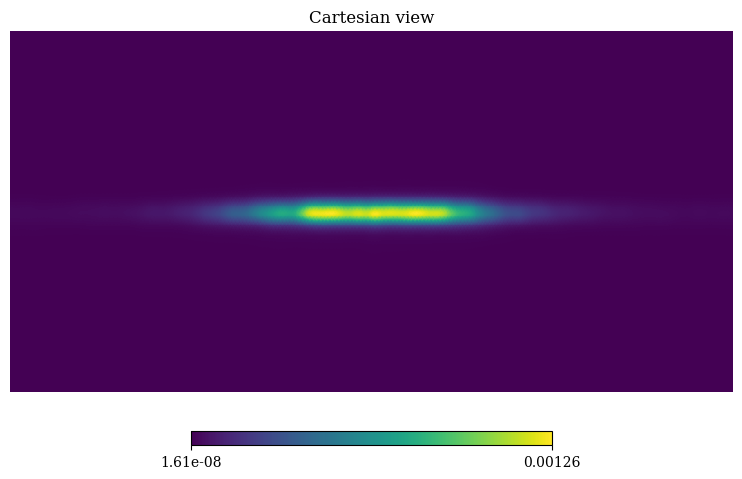

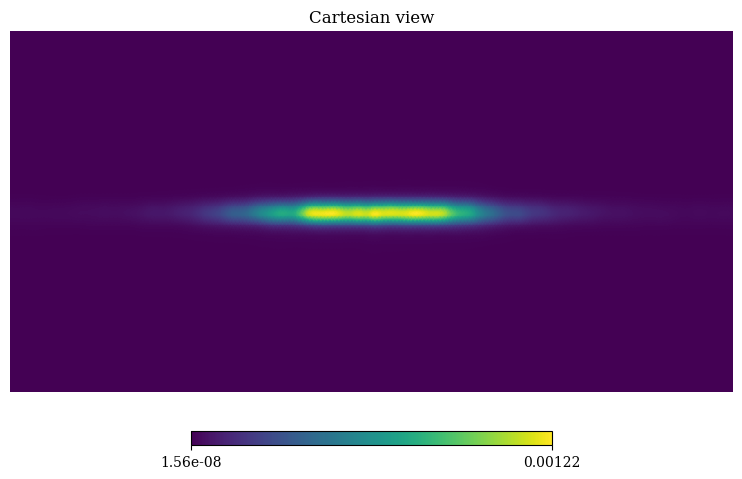

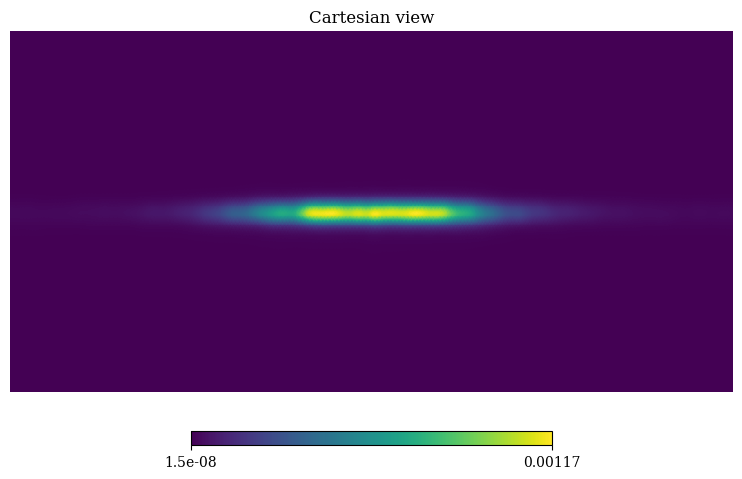

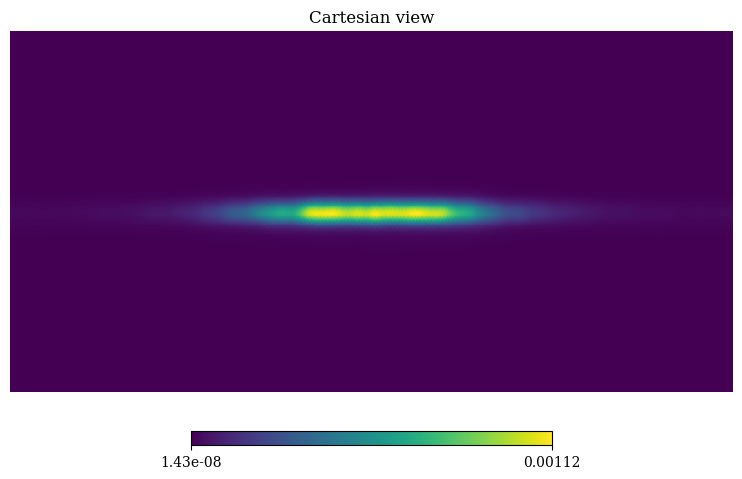

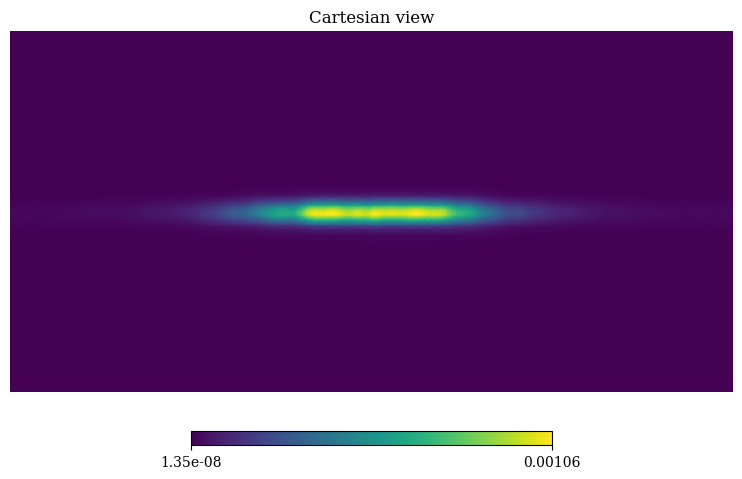

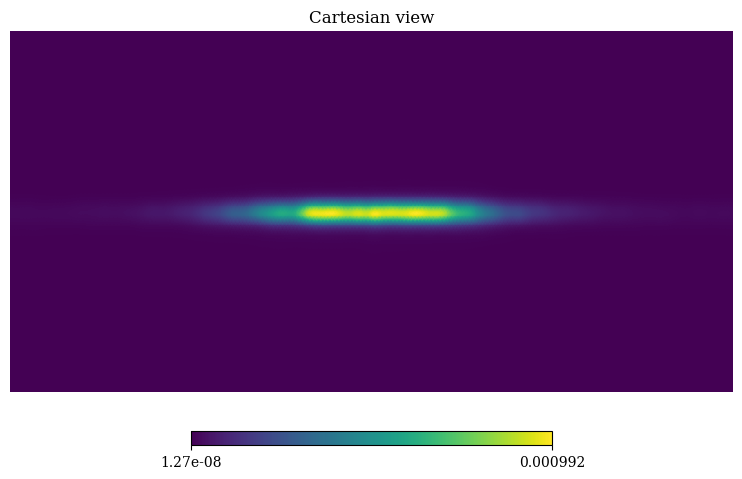

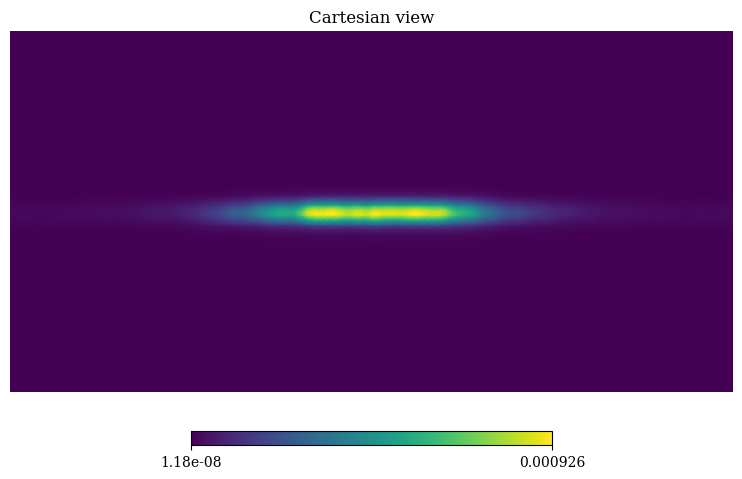

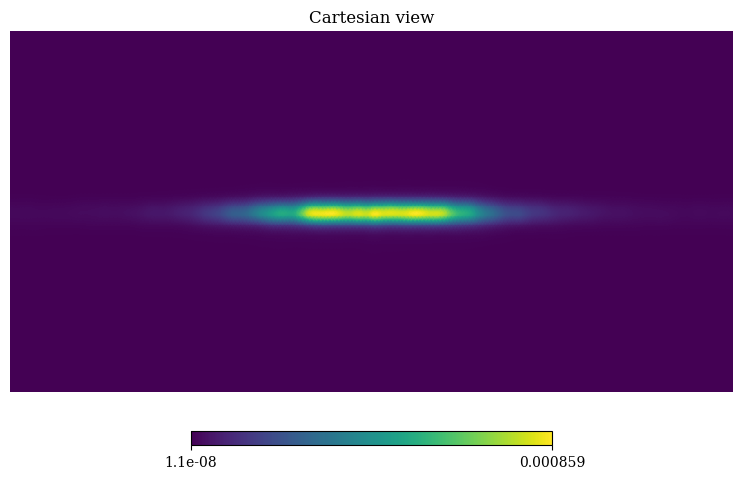

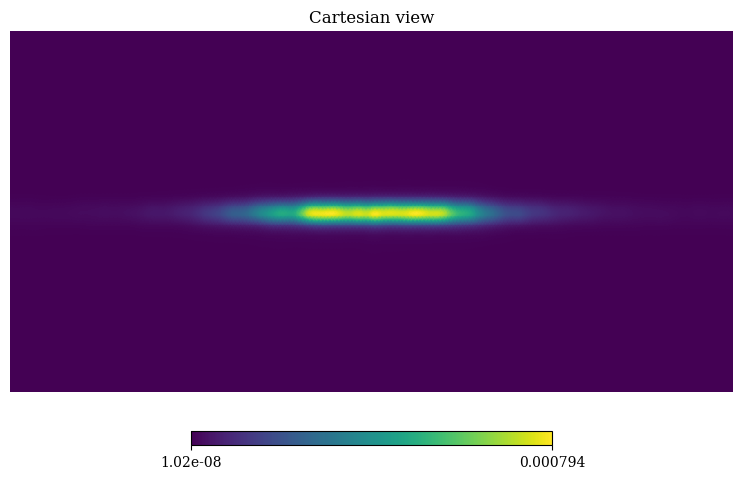

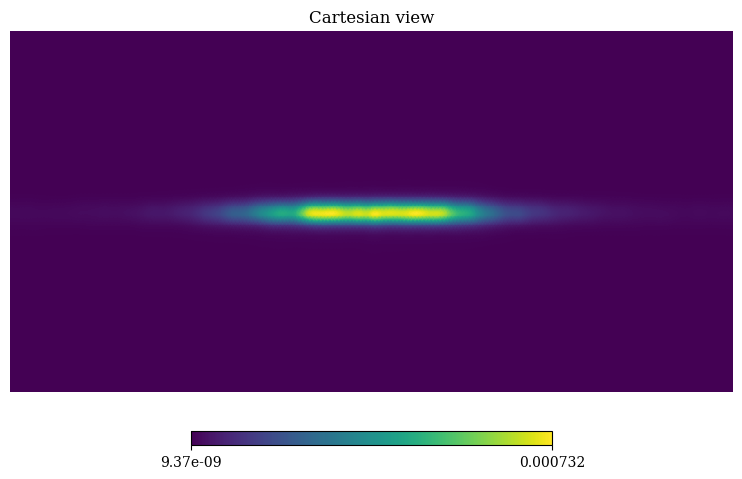

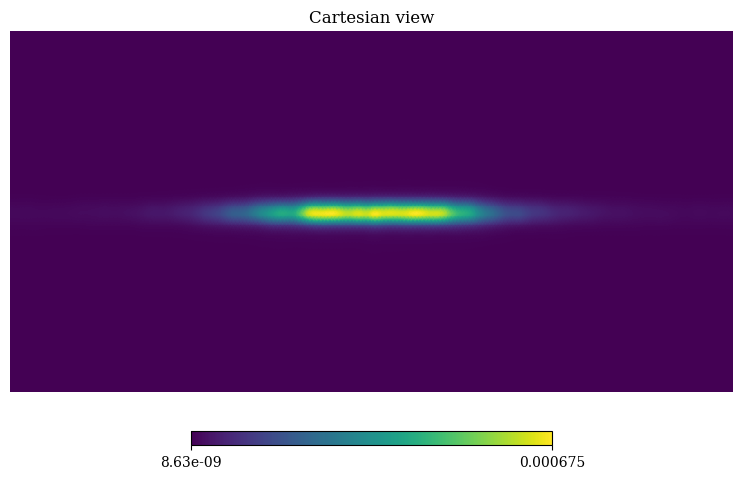

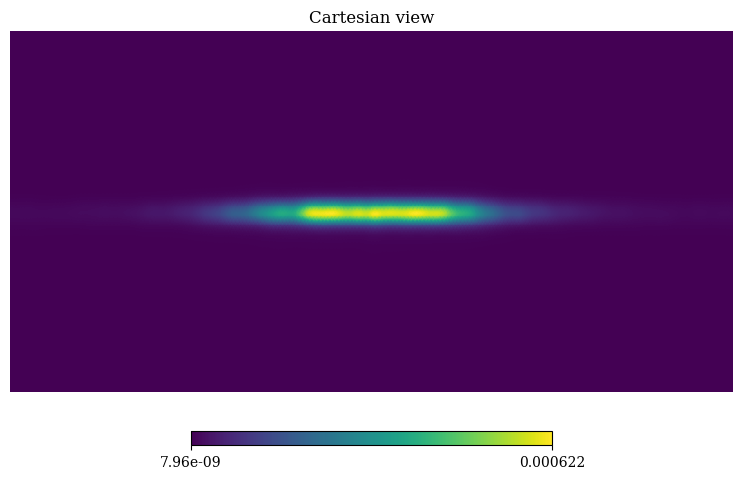

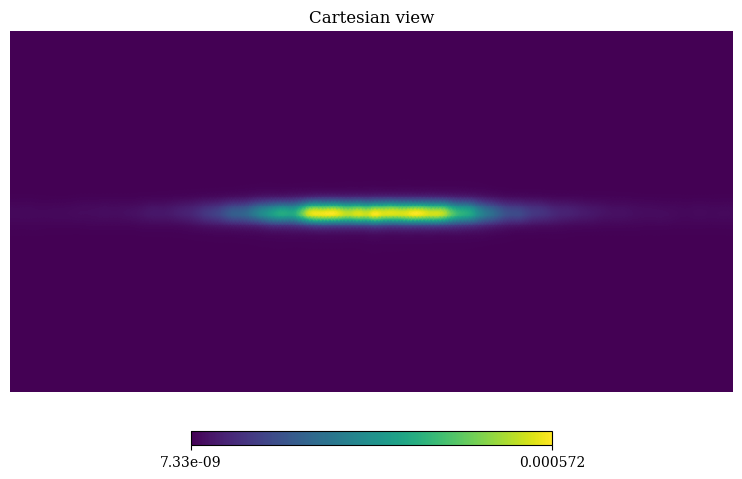

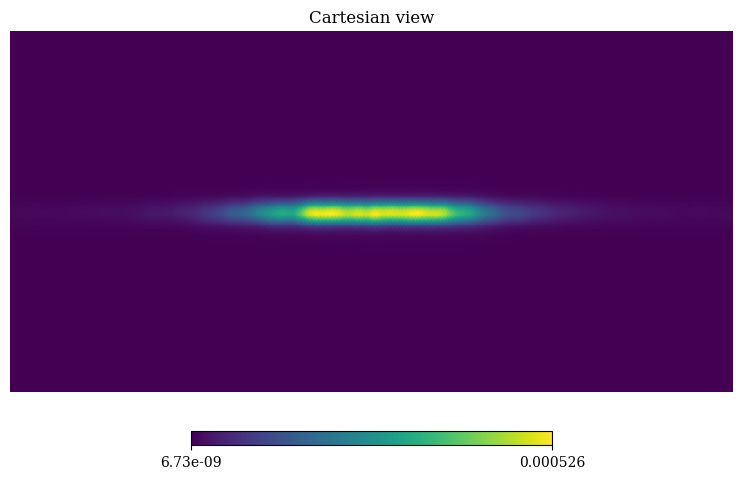

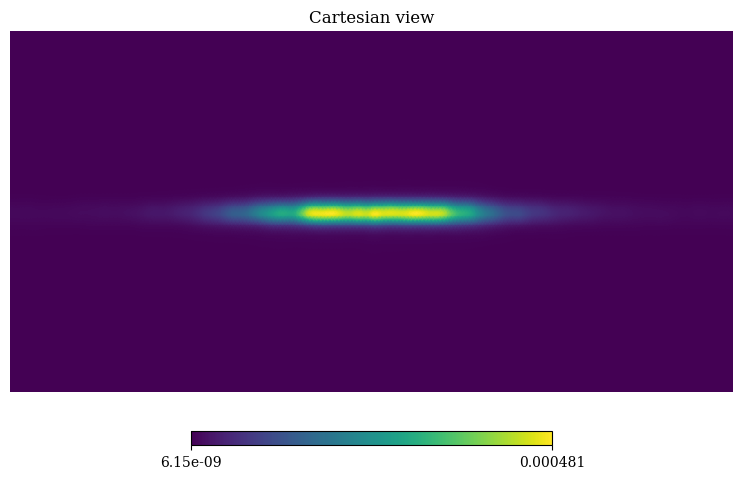

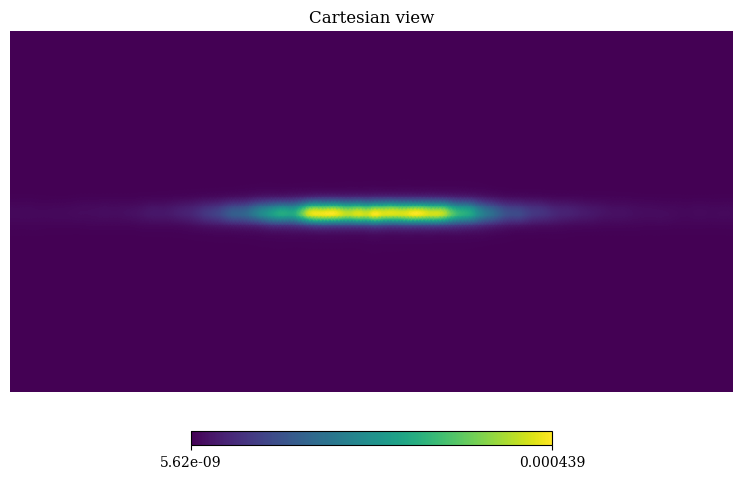

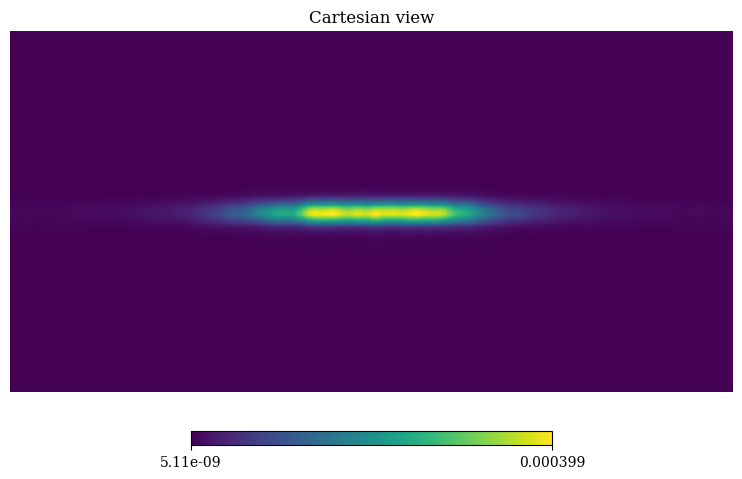

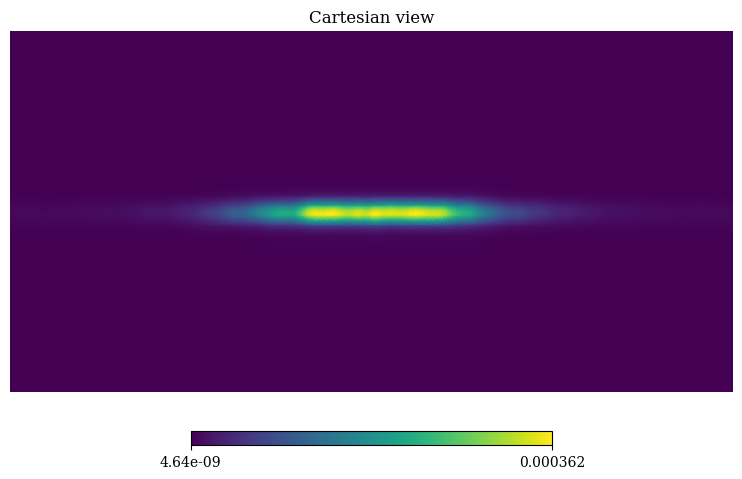

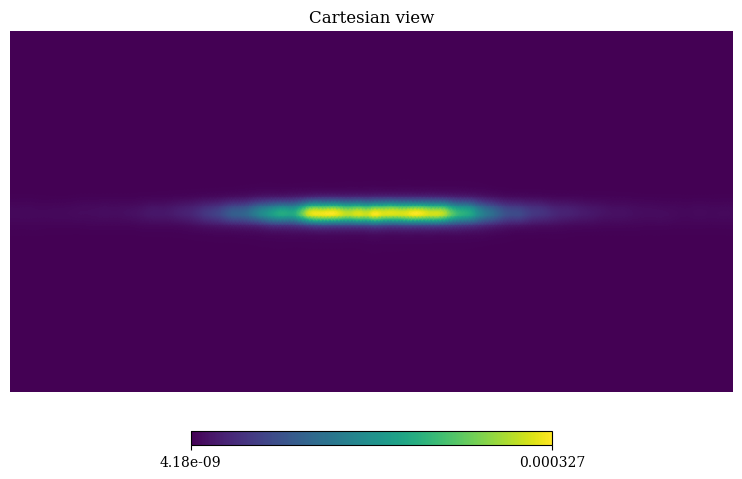

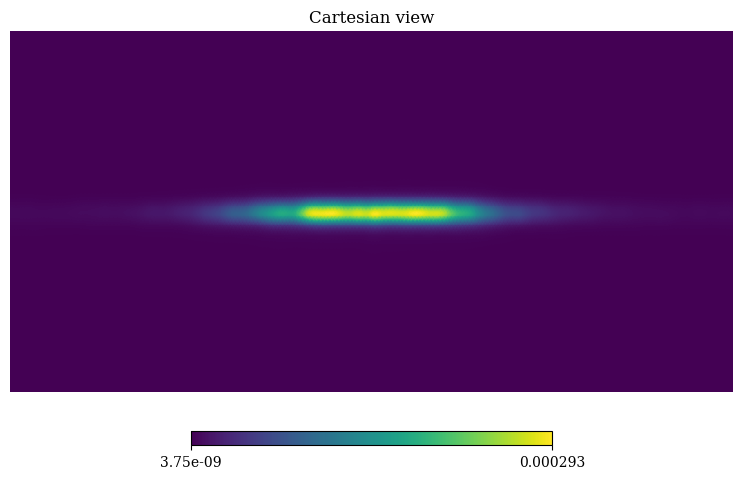

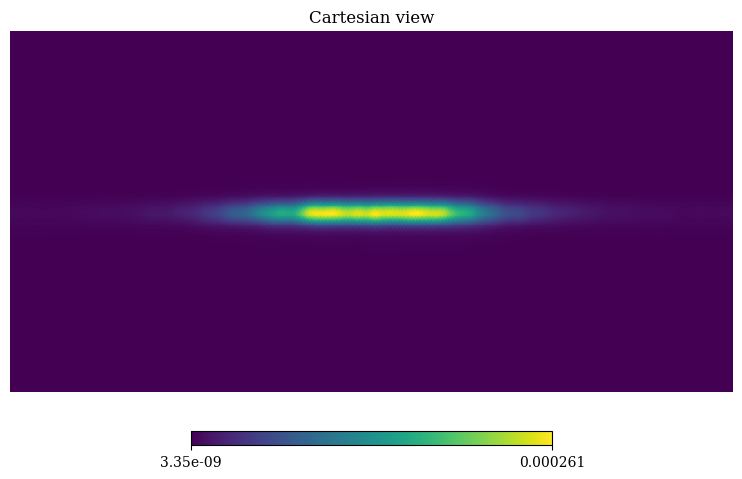

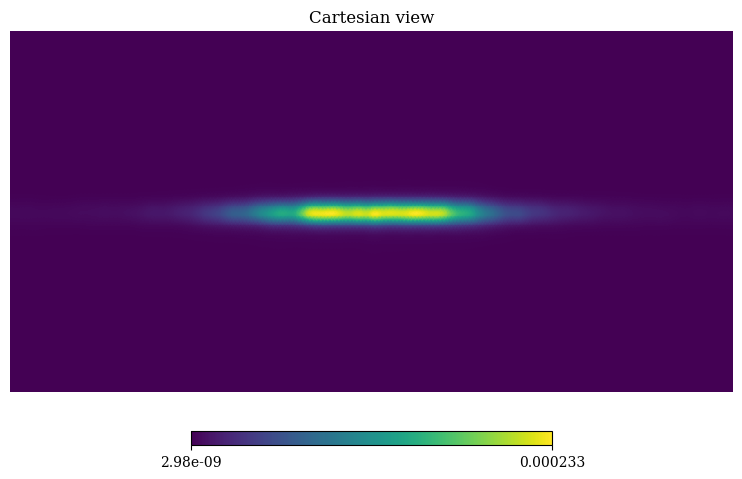

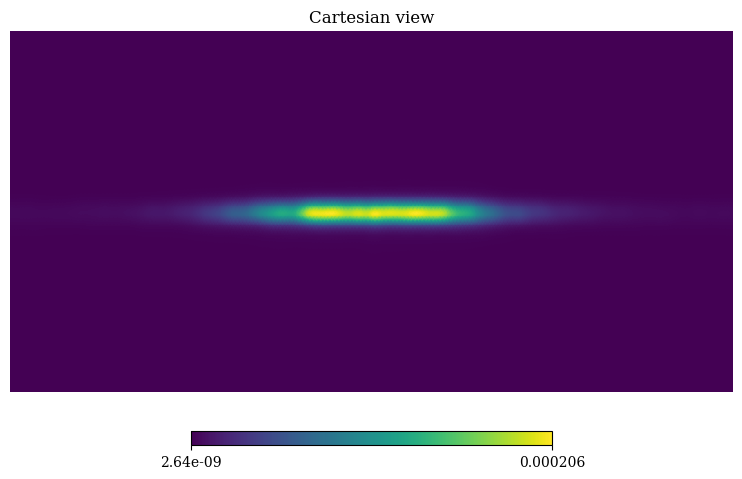

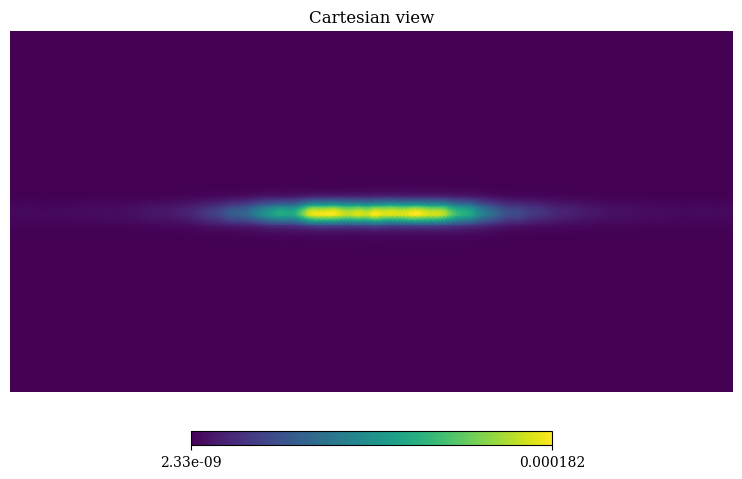

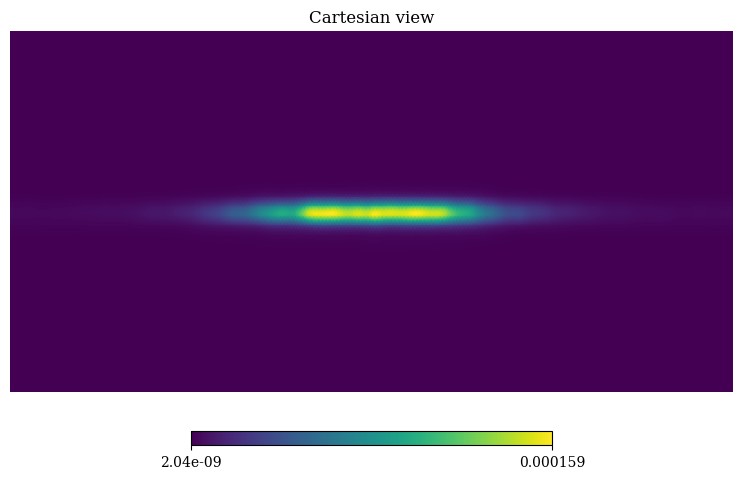

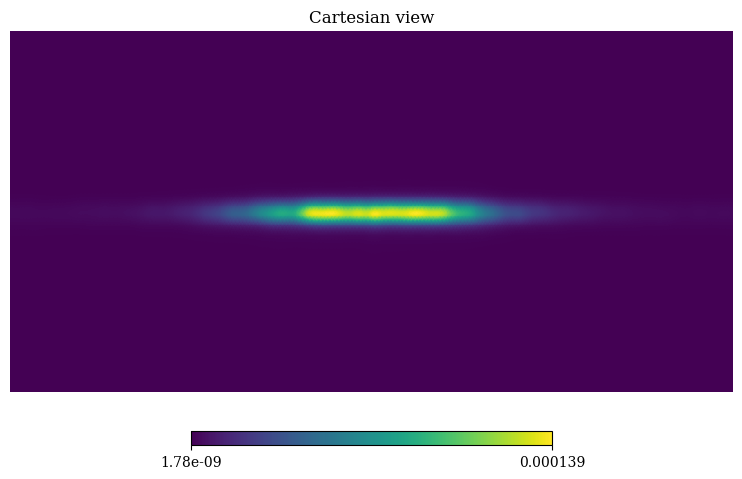

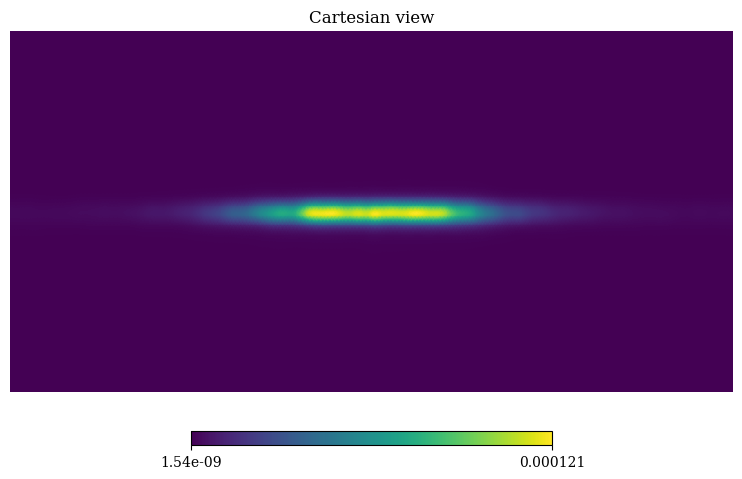

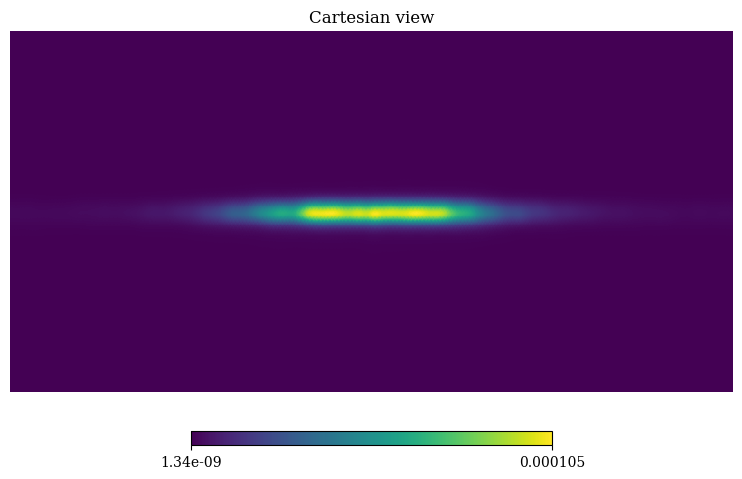

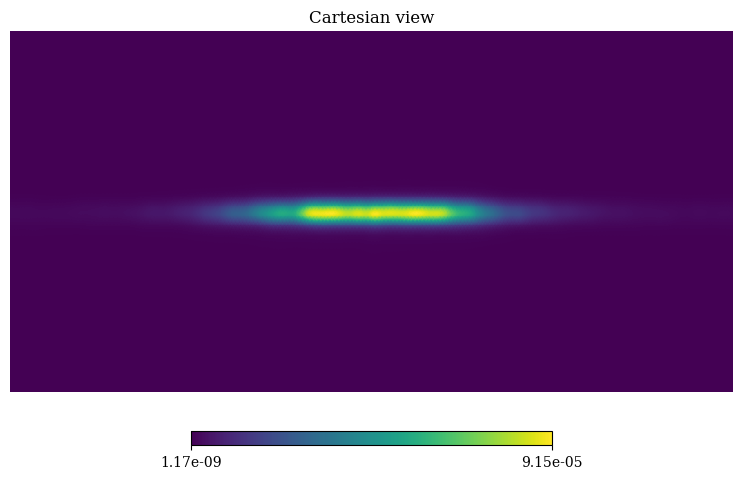

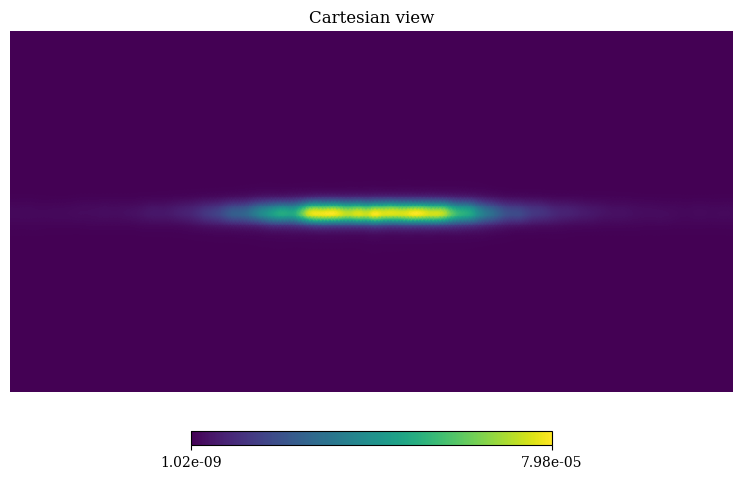

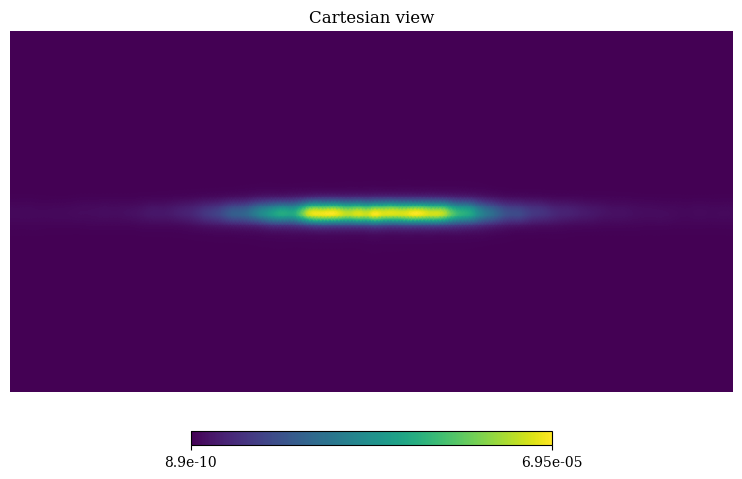

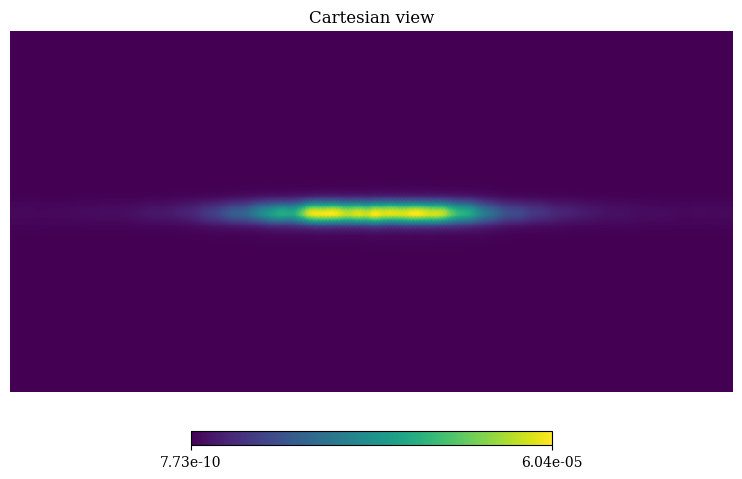

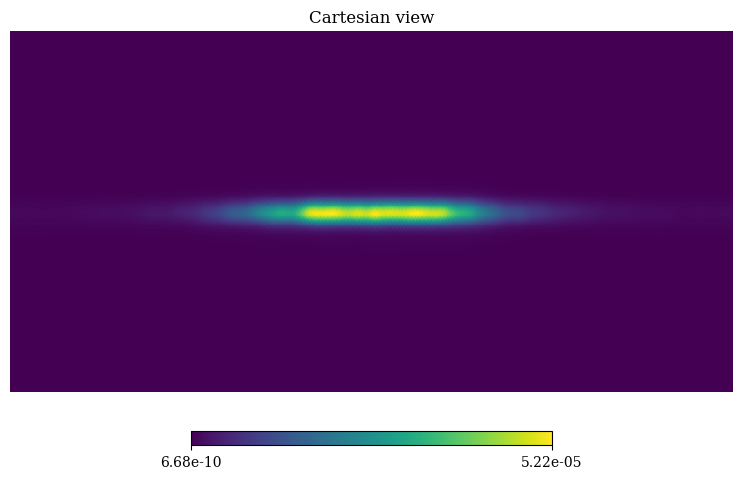

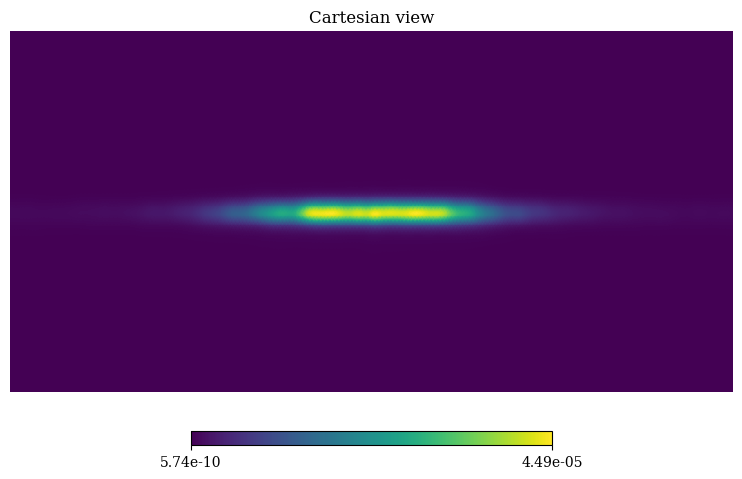

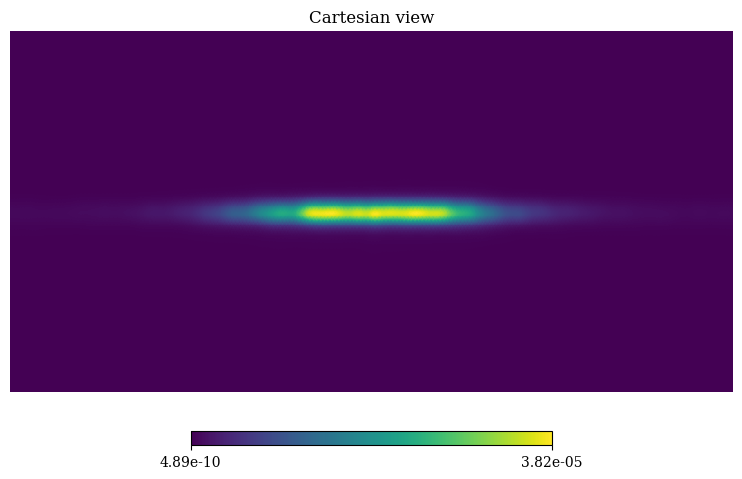

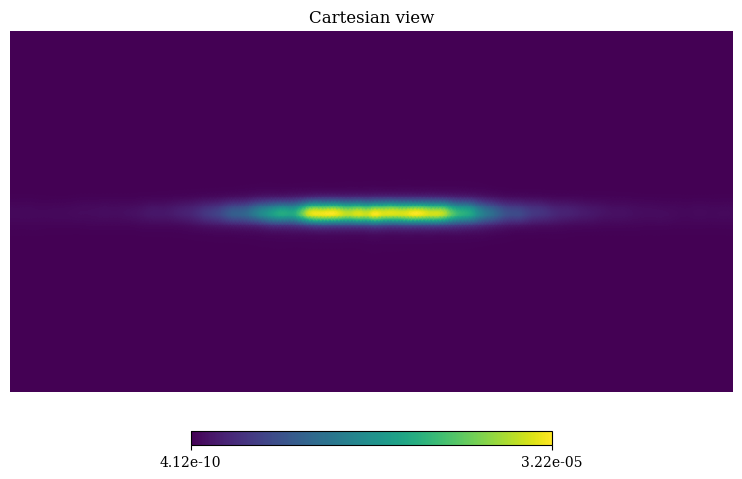

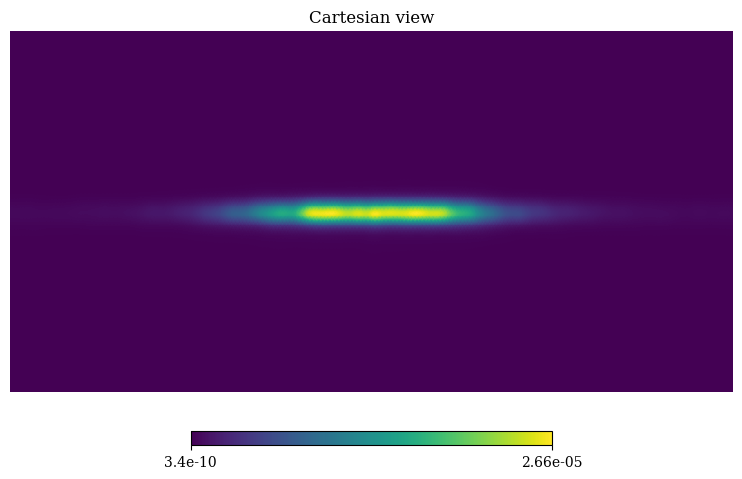

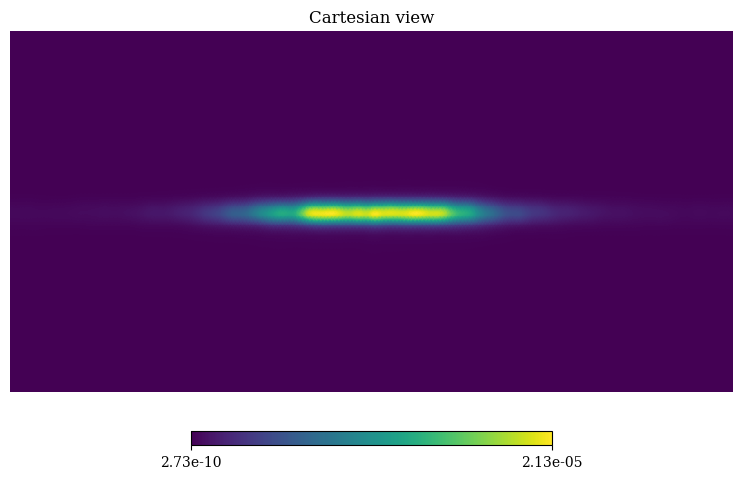

In [193]:
@time anglesmearbin(0, 21.8, 2.7)